In [0]:
## General

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import operator
sns.set()


## Machine Learning

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, roc_curve, f1_score, mean_squared_error
from sklearn.svm import SVR


import warnings
warnings.filterwarnings('ignore')

In [0]:
X = pd.read_csv('train.csv')
X_to_predict = pd.read_csv('test.csv')
Y = pd.read_csv('Y.csv')
IPO_file = pd.read_excel('IPO_data_to_predict.xlsx', index_col=0)

In [0]:
SEED = 12345

_For each **Prediction**, we will implement several model and select the best one based on performance metric._

# Useful functions

In [0]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition 
    
    Args:
        cm         an sklearn confusion matrix
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [0]:
def plot_roc(y_true, predictions, models, title='ROC Curves', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(len(predictions)):
        fpr, tpr, _ = roc_curve(y_true, predictions[i])
        plt.plot(fpr, tpr, label=models[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.legend()
    plt.show()

In [0]:
def compute_roc_auc_test(estimator,model,X_train,Y_train,X_test,Y_test):
    
    estimator.fit(X_train,Y_train)
    Y_pred_test = estimator.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(Y_test,Y_pred_test)
    
    print(model + '// the roc AUC score on test set is: {}'.format(auc_test))

In [0]:
def optimize_threshold(estimator,model,X_train,Y_train, X_test, Y_test, train_val_split=0.20):
    
    '''
    This function permits to tune the probability threshold on a trained model,
    the probability is tuned on a validation set.
    '''
    estimator.fit(X_train,Y_train)
     
    
    thresholds = np.linspace(0,1,30)
    
    best_obj = 0
    OBJ =[]
    best_th = 0
    for th in thresholds:
        
        y_pred = (estimator.predict_proba(X_test)[:,1] > th).astype(int)
        cm = confusion_matrix(Y_test,y_pred)
        TPR = cm[1,1]/(cm[1,0]+cm[1,1])
        FPR = cm[0,1]/(cm[0,0]+cm[0,1])
        OBJ.append(TPR-FPR)
        
        if OBJ[-1] >= best_obj:
            
            best_obj = OBJ[-1]
            best_th = th
            best_cm = cm
    plt.figure(figsize=(10, 10))        
    plt.plot(thresholds,OBJ)
    plt.ylabel('OBJECTIVE')
    plt.xlabel('Threshold')
    plt.title(model+'    ' + 'best Objective: {} // best threshold: {}'.format(best_obj,best_th))
    plt.show()
    ax= plt.subplot()
    plot_confusion_matrix(best_cm)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
        
    return best_th 

In [0]:
def predict_classifier(estimator,best_threshold,X_train,Y_train,X_to_predict):
    
    "Final training and prediction on unseen dataset where ground truth label is not available"
    
    estimator.fit(X_train,Y_train)
    Y_proba = estimator.predict_proba(X_to_predict)[:,1]
    Y_pred = (Y_proba > best_threshold)
    
    return Y_pred
    
    

In [0]:
def feature_importance_rf(pipeline,X_train,Y_train, title):
    
    columns_chosen = X_train.columns[pipeline.named_steps.Selection.get_support()]
    columns_discarded = X_train.columns[pipeline.named_steps.Selection.get_support()==0]
    
    
    plt.figure(figsize=(10,10))
    plt.barh(y=columns_chosen[np.argsort(pipeline.named_steps.Model.feature_importances_)],width=np.sort(pipeline.named_steps.Model.feature_importances_))
    plt.title(title)
    plt.xlabel('feature importance')
    plt.ylabel('feature name')
    plt.show()
    

In [0]:
def feature_importance_lr(pipeline,X_train,Y_train, title):
    
    columns_chosen = X_train.columns[(pipeline.named_steps['Model'].coef_).reshape(-1)!=0]
    columns_discarded = X_train.columns[(pipeline.named_steps['Model'].coef_==0).reshape(-1)]
    coefs = pipeline.named_steps['Model'].coef_
    coefs = coefs[coefs!=0]
    if len(columns_discarded) != 0:
      print('The logit model discarded the following features :',  list(columns_discarded))
    plt.figure(figsize=(10,10))
    plt.barh(y=columns_chosen[np.argsort(coefs)],width=np.sort(coefs))
    plt.title(title)
    plt.xlabel('feature importance')
    plt.ylabel('feature name')
    plt.show()

In [0]:
def compare_models(X, Y, X_train, Y_train, X_test, Y_test, X_to_predict, score, maximize, predict_proba):
    #declare all models to be compared
    dummy           = DummyClassifier(strategy = 'prior', random_state = SEED)
    logit_lasso     = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = SEED, n_jobs= -1)
    logit_ridge     = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = SEED, n_jobs = -1)
    knn             = KNeighborsClassifier(n_jobs = -1)
    random_forest   = RandomForestClassifier(random_state = SEED)
    rf_feature_selection = SelectKBest(f_classif)
    print('Models defined')
    
    #define scaler
    scaler = MinMaxScaler()
    
    #define pipelines
    pipeline_dummy = Pipeline(steps=[('Scaler', scaler), ('Model', dummy)])
    pipeline_lasso = Pipeline(steps=[('Scaler', scaler), ('Model', logit_lasso)])
    pipeline_ridge = Pipeline(steps=[('Scaler', scaler), ('Model', logit_ridge)])
    pipeline_knn   = Pipeline(steps=[('Scaler', scaler), ('Model', knn)])
    pipeline_rf    = Pipeline(steps=[('Selection', rf_feature_selection), ('Model', random_forest)])
    print('Pipelines defined')
    
    #define grids
    grid_logit = {'Model__C': np.logspace(-5, 5, num=50), 'Model__class_weight' : [None, 'balanced']}
    grid_knn   = {'Model__n_neighbors': np.linspace(1, 500, 100, dtype=np.int32)}
    grid_rf    = {'Selection__k': list(range(1,X_train.shape[1]+1,5)), 'Model__n_estimators': [50,100,150,200], 'Model__class_weight' : [None, 'balanced']}
    
    scorer = make_scorer(score, greater_is_better=maximize)
    #define grid searches
    gs_lasso = GridSearchCV(estimator=pipeline_lasso, param_grid=grid_logit, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
    gs_ridge = GridSearchCV(estimator=pipeline_ridge, param_grid=grid_logit, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
    gs_knn   = GridSearchCV(estimator=pipeline_knn, param_grid=grid_knn, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
    gs_rf    = GridSearchCV(estimator=pipeline_rf, param_grid=grid_rf, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
    
    #run searches
    gs_lasso.fit(X_train, Y_train.values.reshape(-1))
    print('Lasso grid search done')
    gs_ridge.fit(X_train, Y_train.values.reshape(-1))
    print('Ridge grid search done')
    gs_knn.fit(X_train, Y_train.values.reshape(-1))
    print('KNN grid search done')
    gs_rf.fit(X_train, Y_train.values.reshape(-1))
    print('Random Forest grid search done')
    print('Gird searches finished\n')
    
    print('Let us take a look at the best parameters found')
    print('Model'.center(30), 'Parameters'.center(30), 'Best Value'.center(30))
    print('='*90)
    print(str('LogitLasso').center(30), str('penalty C').center(30), str(gs_lasso.best_params_['Model__C']).center(30))
    print(str('LogitLasso').center(30), str('class weight').center(30), str(gs_lasso.best_params_['Model__class_weight']).center(30))
    print(str('LogitRidge').center(30), str('penalty C').center(30), str(gs_ridge.best_params_['Model__C']).center(30))
    print(str('LogitRidge').center(30), str('class weight').center(30), str(gs_ridge.best_params_['Model__class_weight']).center(30))
    print(str('KNN').center(30), str('number of neighbors K').center(30), str(gs_knn.best_params_['Model__n_neighbors']).center(30))
    print(str('RandomForest').center(30), str('number of features to select k').center(30), str(gs_rf.best_params_['Selection__k']).center(30))
    print(str('RandomForest').center(30), str('number of trees').center(30), str(gs_rf.best_params_['Model__n_estimators']).center(30))
    print(str('RandomForest').center(30), str('class weight').center(30), str(gs_rf.best_params_['Model__class_weight']).center(30))
    print('\n')
    
    #set parameters to best ones found
    pipeline_lasso.set_params(Model__C = gs_lasso.best_params_['Model__C'], Model__class_weight = gs_lasso.best_params_['Model__class_weight'])   
    pipeline_ridge.set_params(Model__C = gs_ridge.best_params_['Model__C'], Model__class_weight = gs_ridge.best_params_['Model__class_weight'])   
    pipeline_knn.set_params(Model__n_neighbors = gs_knn.best_params_['Model__n_neighbors'])   
    pipeline_rf.set_params(Selection__k = gs_rf.best_params_['Selection__k'], 
                           Model__n_estimators = gs_rf.best_params_['Model__n_estimators'], 
                           Model__class_weight = gs_rf.best_params_['Model__class_weight'])  
    
    #fit the models with the best parameters
    pipeline_dummy.fit(X_train, Y_train)
    pipeline_lasso.fit(X_train, Y_train)
    pipeline_ridge.fit(X_train, Y_train)
    pipeline_knn.fit(X_train, Y_train)
    pipeline_rf.fit(X_train, Y_train)
    print('Models trained\n')
    
    print('Now we take a look at the importance attributed to each feature by the models : First the Logit model with Lasso, then the logit with ridge, and finally random forest.')
    print('In the graph below you can see the features importance for the logit model with Lasso regularization : \n')
    feature_importance_lr(pipeline_lasso, X_train, Y_train, 'Features importance in the Logit model with Lasso')
    print('In the graph below you can see the features importance for the logit model with Ridge regularization : \n')
    feature_importance_lr(pipeline_ridge, X_train, Y_train, 'Features importance in the Logit model with Ridge')
    print('In the graph below you can see the features importance for the RandomForest model: \n')
    feature_importance_rf(pipeline_rf, X_train, Y_train, 'Features importance in the RandomForest model')
    print('\n')
    
    #compute predictions for the test set
    predictions_dummy = pipeline_dummy.predict_proba(X_test)[:,1]
    predictions_lasso = pipeline_lasso.predict_proba(X_test)[:,1]
    predictions_ridge = pipeline_ridge.predict_proba(X_test)[:,1]
    predictions_knn   = pipeline_knn.predict_proba(X_test)[:,1]
    predictions_rf    = pipeline_rf.predict_proba(X_test)[:,1]
    print('Models predictions computed\n')
    predictions = [predictions_dummy, predictions_lasso, predictions_ridge, predictions_knn, predictions_rf]
    models = ['Dummy', 'LogitLasso', 'LogitRidge', 'KNN', 'RandomForest']
    
    print('After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.')
    plot_roc(Y_test, predictions, models)
    
    #compute the scores
    score_dummy = score(Y_test.to_numpy(), predictions_dummy)
    score_lasso = score(Y_test.to_numpy(), predictions_lasso)
    score_ridge = score(Y_test.to_numpy(), predictions_ridge)
    score_knn   = score(Y_test.to_numpy(), predictions_knn)
    score_rf    = score(Y_test.to_numpy(), predictions_rf)
    
    scores = [score_dummy, score_lasso, score_ridge, score_knn, score_rf]
    
    #find model with best score on testing set
    if maximize:
        ind, best_score = max(enumerate(scores), key=operator.itemgetter(1))
    else:
        ind, best_score = min(enumerate(scores), key=operator.itemgetter(1))
    best_model      = models[ind]
    print('Scores computed and compared\n')
    
    print ('We need to compare the scores between models in order to make our choice, the table below makes the comparison easier')
    print('Model'.center(30), 'Score'.center(30))
    print('='*60)
    for i in range(5):
        print(str(models[i]).center(30), str(scores[i]).center(30))
    
    print('\n\n')
    print('The best model for this prediction is ', best_model)
    print('It yields a score of ', best_score)
    print('\n')
    
    if ind == 0:
        pipeline_dummy.fit(X, Y)
        if predict_proba == True:
            P = pipeline_dummy.predict_proba(X_to_predict)[:,1]
        else:
            print('Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.')
            best_threshold = optimize_threshold(pipeline_dummy, model='Dummy model', X = X, Y = Y, X_train=X_train,Y_train=Y_train, X_test=X_test, Y_test=Y_test)
            print('The best Threshold Found is ', best_threshold)
            P = predict_classifier(pipeline_dummy, best_threshold, X, Y , X_to_predict)
    elif ind == 1:
        pipeline_lasso.fit(X, Y)
        if predict_proba == True:
            P = pipeline_lasso.predict_proba(X_to_predict)[:,1]
        else:
            print('Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.')
            best_threshold = optimize_threshold(pipeline_lasso, model='Logistic Regression (with Lasso)', X_train=X_train,Y_train=Y_train, X_test=X_test, Y_test=Y_test)
            P = predict_classifier(pipeline_lasso, best_threshold, X, Y , X_to_predict)
    elif ind == 2:
        pipeline_ridge.fit(X, Y)
        if predict_proba == True:
            P = pipeline_ridge.predict_proba(X_to_predict)[:,1]
        else:
            print('Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.')
            best_threshold = optimize_threshold(pipeline_ridge, model='Logistic Regression (with Ridge)', X_train=X_train,Y_train=Y_train, X_test=X_test, Y_test=Y_test)
            P = predict_classifier(pipeline_ridge, best_threshold, X, Y , X_to_predict)
    elif ind == 3:
        Y_pred = pipeline_knn.predict(X_test)
        cm = confusion_matrix(Y_test,Y_pred)
        plot_confusion_matrix(cm)
        pipeline_knn.fit(X, Y)
        if predict_proba == True:
            P = pipeline_knn.predict_proba(X_to_predict)[:,1]
        else:
            P = pipeline_knn.predict(X_to_predict)
    elif ind == 4:
        pipeline_rf.fit(X, Y)
        if predict_proba == True:
            P = pipeline_rf.predict_proba(X_to_predict)[:,1] 
        else:
            print('Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.')
            best_threshold = optimize_threshold(pipeline_rf, model='RandomForest', X_train=X_train,Y_train=Y_train, X_test=X_test, Y_test=Y_test)
            P = predict_classifier(pipeline_rf, best_threshold, X, Y , X_to_predict)
    
    return P, best_model, best_score
        

# Introduction

_This notebook provides the 9 prediction tasks regarding change in stock price on first day IPO._

The general procedure to tune, evaluate and select best model is analogue in each prediction task. First, we build a **pipeline** to scale and select relevant features, and then we apply the model. Hyper-parameters selection is made through a grid search on a **5-folds Cross Validation** and model performance is evaluated on 
a test set that includes 20% of the **`train`** data frame, the remaining 80% are used for training and tuning.

In addition, we perform some probability threshold selection based on a custom score for the binary classification tasks and provide feature importance for models who has this capability.

Except for the regression task **P6**,
we make the use of `compare_models`, our own custom-made function that pipelines, trains, tunes, tests models to select the best and compute optimal threshold as well as feature importance. Finally, this function train the best model on all the labelled data, and predict on "data-to-predict" data.

**Model Selection**

- For each prediction task, we define the metric that will be used for evaluating performance. Then, 
  this is the performance  on the hold-out test set (20% of the labeled data) which is used to assess this       performance.

# A. Binary Classification Problems P1,P2,P3,P4,P5

_As a baseline, we use:_

- KNN Classifier
- Dummy Classiifer

_Advanced models:_

- Ridge Logistic Regression: tuning on **C** (inverse of penalty coef.) and **class_weight**
- Lasso Logistic Regression: tuning on **C** and **class_weight**
- Random Forest: tuning on **n_estimators** and **class_weight**

The motivation for this choice of models is that we wanted to test radically different approachs, one based on
a hyper-plane separation of the data (Logistic), and another one (Random Forest) that is more suitable for handling non-linearities through a tree architecture.

_Feature selection_ is made through Lasso/Ridge penalty for Logistic Regression models, while for Random Forest
we tune the number **K** of features during CV based on their F-statistic.

_Feature importance_ for Logistic Lasso/Ridge is simply the coefficient associated to each variable. For Random Forest, it is the feature importance function that measures how well a feature decrease the impurty (i.e. split the data).

_Probability threshold__ is tuned for the best model.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)

# A.1 P1

_Here we aim to predict whether the IPO is underpriced or overpriced._

- In P1, we make the use of all our preprocessed variables except *rf*.


The metric to evaluate model performance is the **roc AUC**. This latter is the area under the roc curve and has a nice interpretation: it is the probability that a random positive sample is ranked higher than a negative one. The problem is unbalanced with approx. 73% of positive samples, accuracy is not a suitable metric and can be very misleading. 

For tuning the probability threshold, we propose a custom metric that considers equally into account the **True Positive Rate** and the **False Positive Rate**. Indeed, we want to maximize **TPR** (i.e. hit rate) while minimizing **FPR** (i.e. false alarm). 

Objective: $$\max_{threshold} TPR-FPR$$

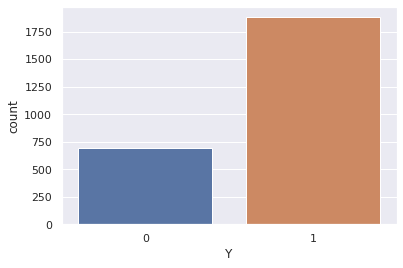

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.2min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.9s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


KNN grid search done
Fitting 5 folds for each of 104 candidates, totalling 520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:  4.6min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                  2.0235896477251556      
          LogitLasso                    class weight                     balanced           
          LogitRidge                     penalty C                  2.0235896477251556      
          LogitRidge                    class weight                     balanced           
             KNN                   number of neighbors K                    1               
         RandomForest          number of features to select k               11              
         RandomForest                 number of trees                       50              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

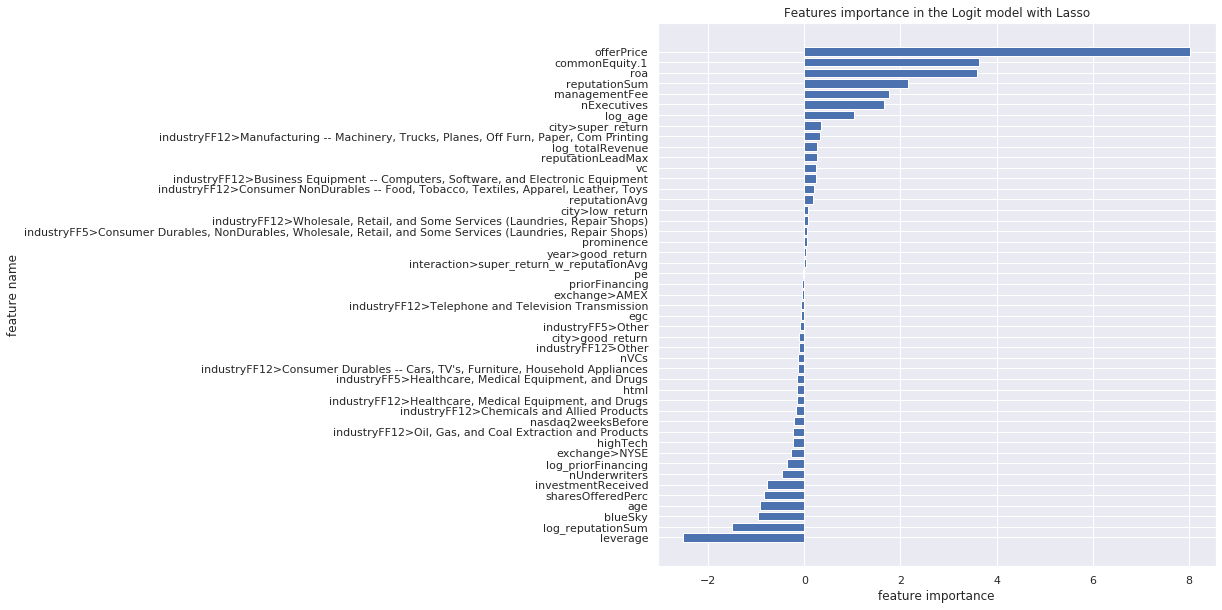

In the graph below you can see the features importance for the logit model with Ridge regularization : 



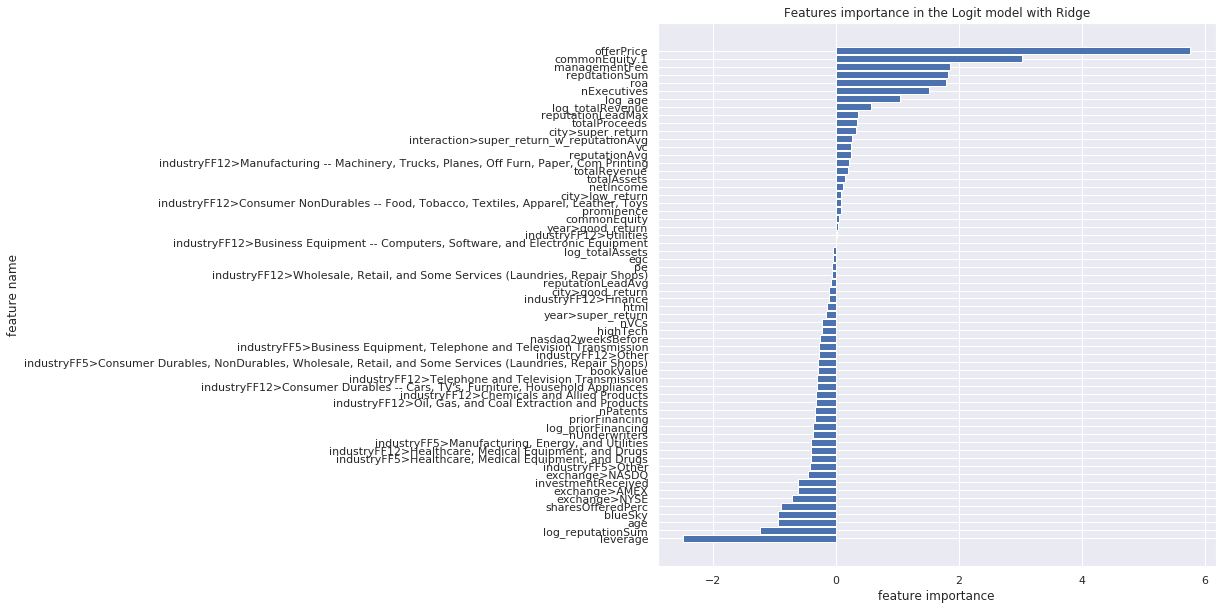

In the graph below you can see the features importance for the RandomForest model: 



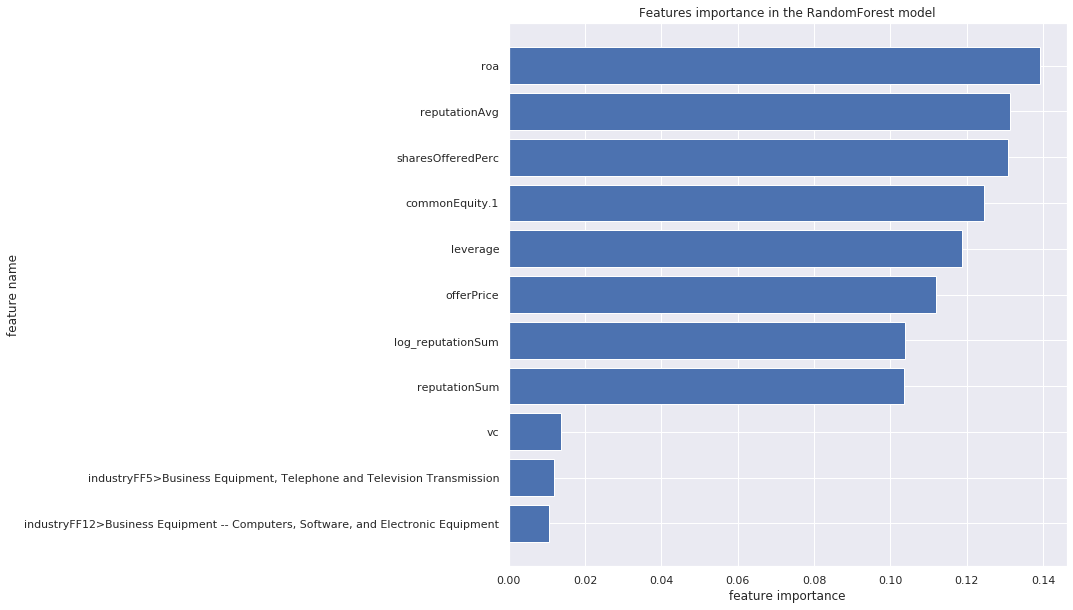



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


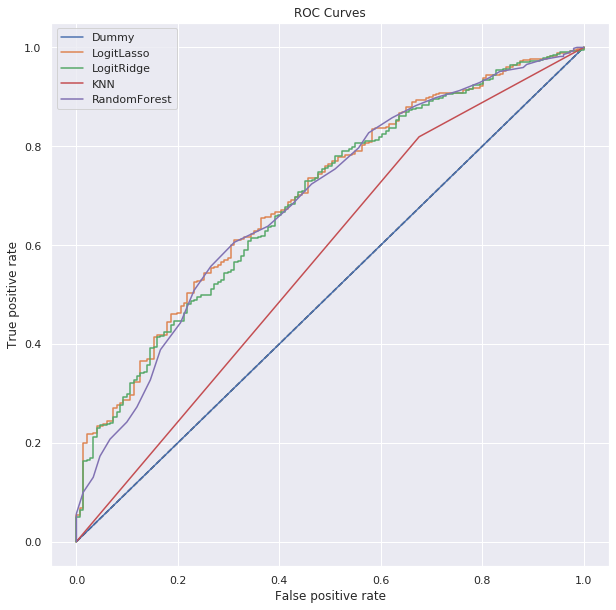

Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                           0.5              
          LogitLasso                 0.6993888978624885      
          LogitRidge                 0.6910299897700964      
             KNN                     0.5718045011575943      
         RandomForest                0.6882571474721368      



The best model for this prediction is  LogitLasso
It yields a score of  0.6993888978624885


Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.


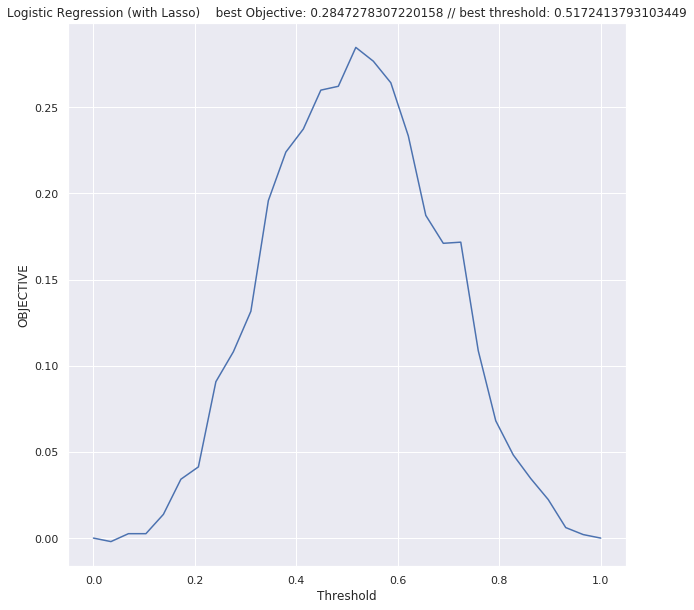

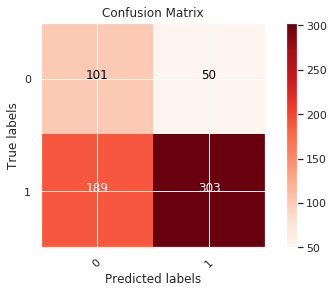

In [17]:
P1_features = X.columns[~X.columns.str.contains(pat = 'rf')]

X_P1            = X[P1_features].copy()
X_train_P1      = X_train[P1_features].copy()
X_test_P1       = X_test[P1_features].copy()
X_to_predict_P1 = X_to_predict[P1_features].copy()
Y_train_P1      = (Y_train > 0).astype(int)
Y_test_P1       = (Y_test > 0).astype(int)
Y_P1            = (Y > 0).astype(int)

sns.countplot(data=Y_train_P1,x='Y')
plt.show()

P1, best_model_P1, best_score_P1 = compare_models(X=X_P1, Y=Y_P1, X_train=X_train_P1, Y_train=Y_train_P1, X_test=X_test_P1, Y_test=Y_test_P1, X_to_predict=X_to_predict_P1, 
                                            score=roc_auc_score, maximize=True, predict_proba=False)

In [18]:
P1

array([ True, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True, False,  True, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False,  True,  True, False,  True,
       False, False,  True, False,  True, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False, False, False, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False, False,  True,
       False,  True, False,  True, False, False, False, False, False,
        True, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,

In [0]:
IPO_file['P1'] = P1

# A.2 P2

- Here we only use `rf`related variables, `industryFF12` and `year`.
- The prediction problem being the same as **P1**, we use the same procedure as well as the same scoring metric for model selection **roc AUC** and the same custom objective for tuning the threshold.


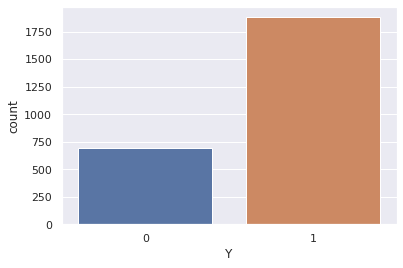

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.8s finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.8s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.7s finished


KNN grid search done
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   45.7s finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                 0.04714866363457394      
          LogitLasso                    class weight                     balanced           
          LogitRidge                     penalty C                0.00010481131341546853    
          LogitRidge                    class weight                     balanced           
             KNN                   number of neighbors K                    6               
         RandomForest          number of features to select k               1               
         RandomForest                 number of trees                       50              
         RandomForest                   class weight                     balanced           


Models trained

Now we take a look at the importance attri

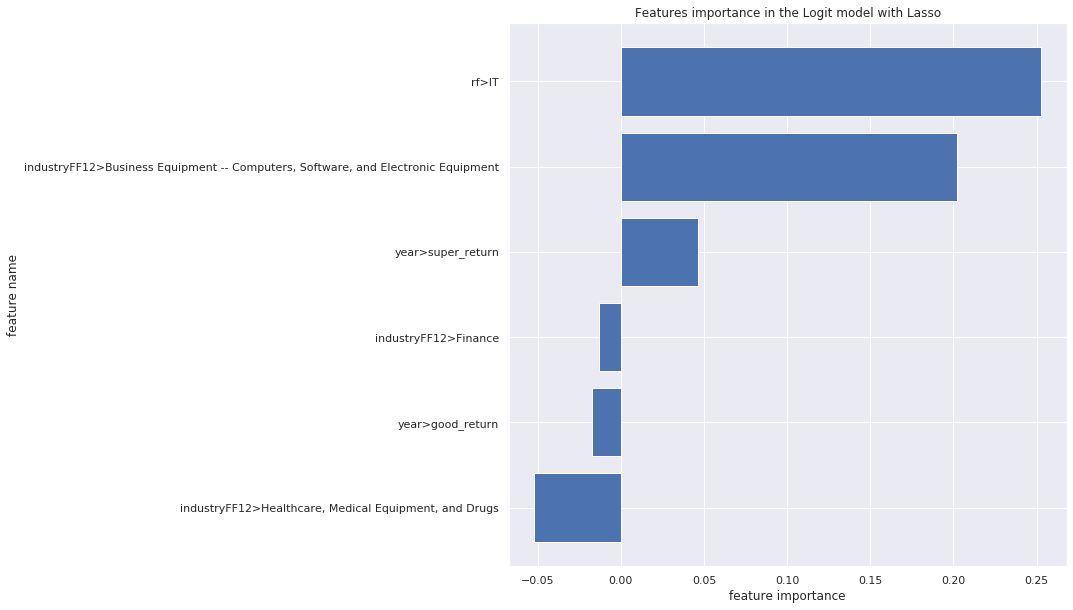

In the graph below you can see the features importance for the logit model with Ridge regularization : 



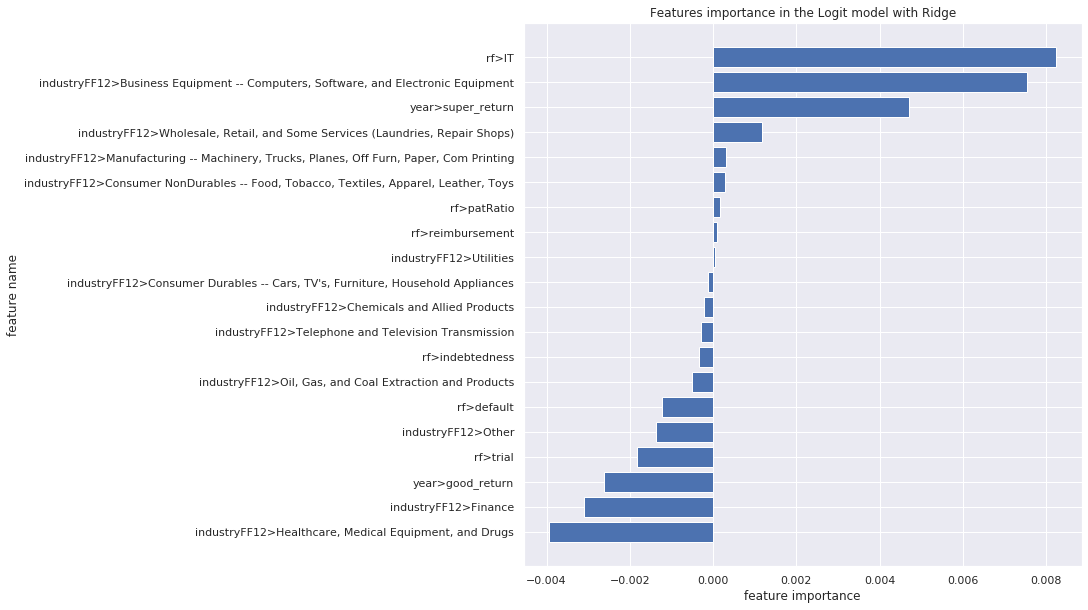

In the graph below you can see the features importance for the RandomForest model: 



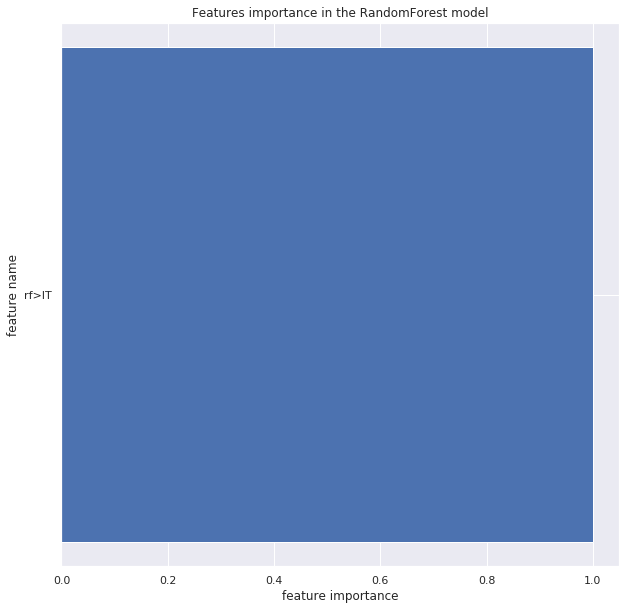



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


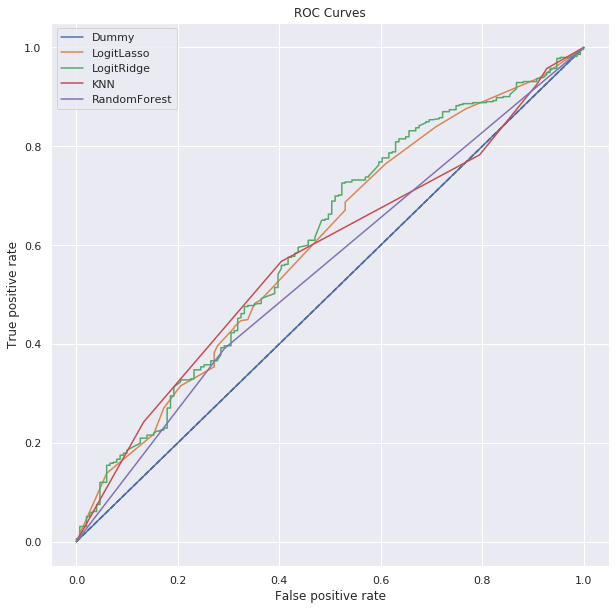

Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                           0.5              
          LogitLasso                 0.598173423787218       
          LogitRidge                 0.6054353093199807      
             KNN                     0.5756003338179078      
         RandomForest                0.5494265869811016      



The best model for this prediction is  LogitRidge
It yields a score of  0.6054353093199807


Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.


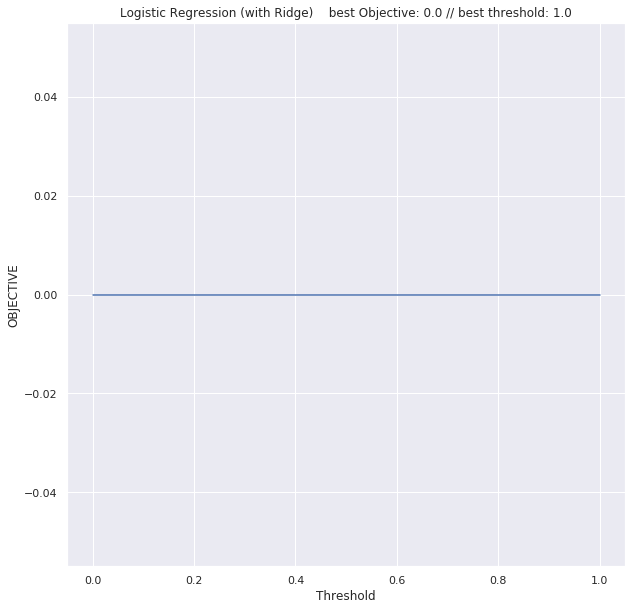

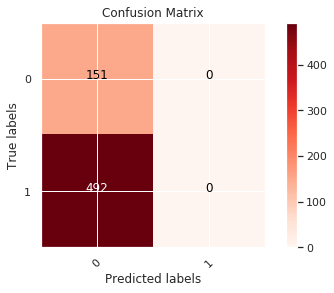

In [23]:
P2_features = X.columns[X.columns.str.contains(pat = 'industryFF12')+X.columns.str.contains(pat = 'rf')+X.columns.str.contains(pat = 'year')]

X_P2            = X[P2_features].copy()
X_train_P2      = X_train[P2_features].copy()
X_test_P2       = X_test[P2_features].copy()
X_to_predict_P2 = X_to_predict[P2_features].copy()
Y_train_P2      = (Y_train > 0).astype(int)
Y_test_P2       = (Y_test > 0).astype(int)
Y_P2            = (Y > 0).astype(int)

sns.countplot(data=Y_train_P2,x='Y')
plt.show()

P2, best_model_P2, best_score_P2 = compare_models(X=X_P2, Y=Y_P2, X_train=X_train_P2, Y_train=Y_train_P2, X_test=X_test_P2, Y_test=Y_test_P2, X_to_predict=X_to_predict_P2, 
                                                  score=roc_auc_score, maximize=True, predict_proba=False)

In [24]:
P2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

- For this second prediction, we obtain an roc AUC on test data which is lower than for prediction 1. Namely because 
we only have risk features extracted from text, year based features and industry related ones. We imputed the 
model from all the predictive information of the other variables that were included in **P1**. Nevertheless,
the optimal classifier, ridge logistic in this case, yields an AUC score above the baseline threshold of 50%.

- Feature importance varies depending on the model used. Lasso and Random Forest set many features to zero.

- Even if the ROC score of the logit model with Ridge regularization is 0.6 for this prediction, it actually ends up being a dummy classifier since it predicts the same value all the time. This might lead us to conclude that the features proposed for this prediction are not sufficient to construct a model that is complex enough to capture the change in the share price.

In [0]:
IPO_file['P2'] = P2

# A.3 P3

- The classification problem is same as before, except that now we are given all the features.
- Scoring metric for evaluation and selection is **roc AUC**.

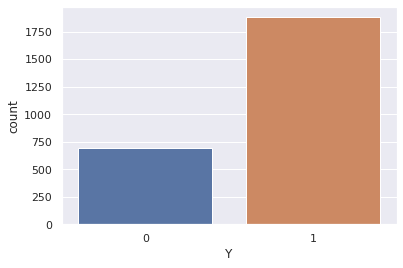

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.3min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.0s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  5.0min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                  54.286754393238596      
          LogitLasso                    class weight                     balanced           
          LogitRidge                     penalty C                  355.64803062231283      
          LogitRidge                    class weight                     balanced           
             KNN                   number of neighbors K                    1               
         RandomForest          number of features to select k               36              
         RandomForest                 number of trees                       50              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

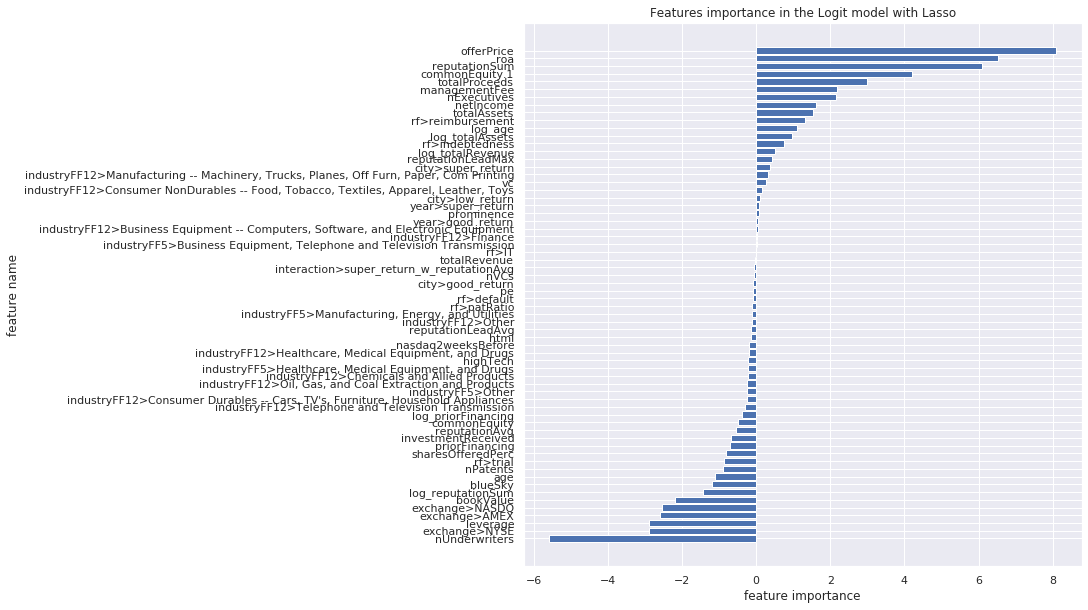

In the graph below you can see the features importance for the logit model with Ridge regularization : 



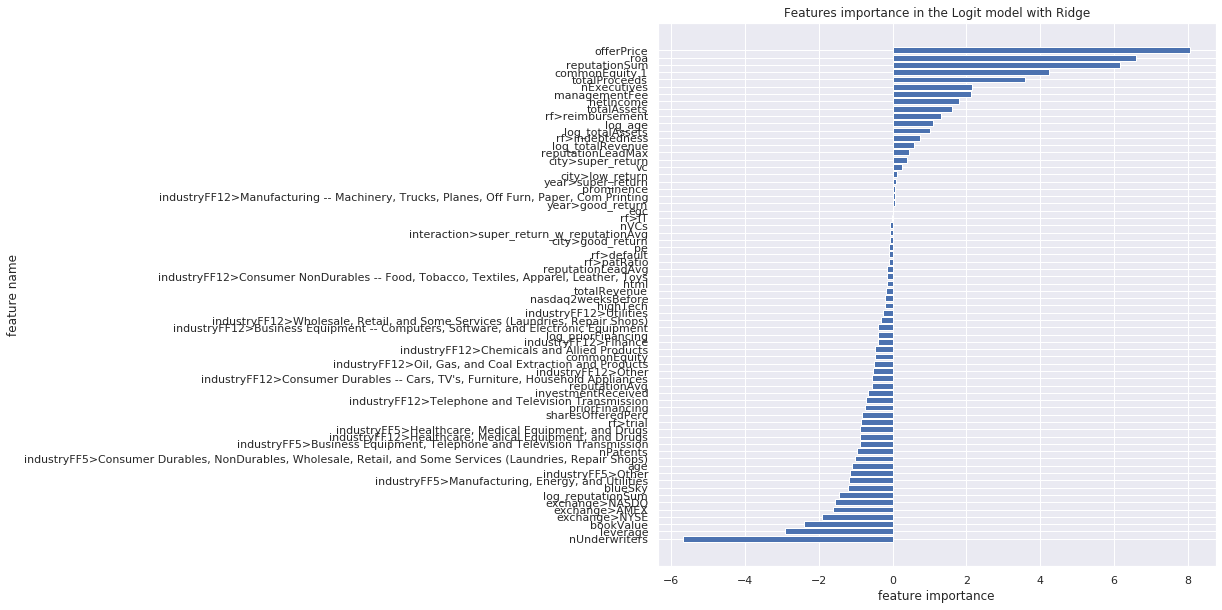

In the graph below you can see the features importance for the RandomForest model: 



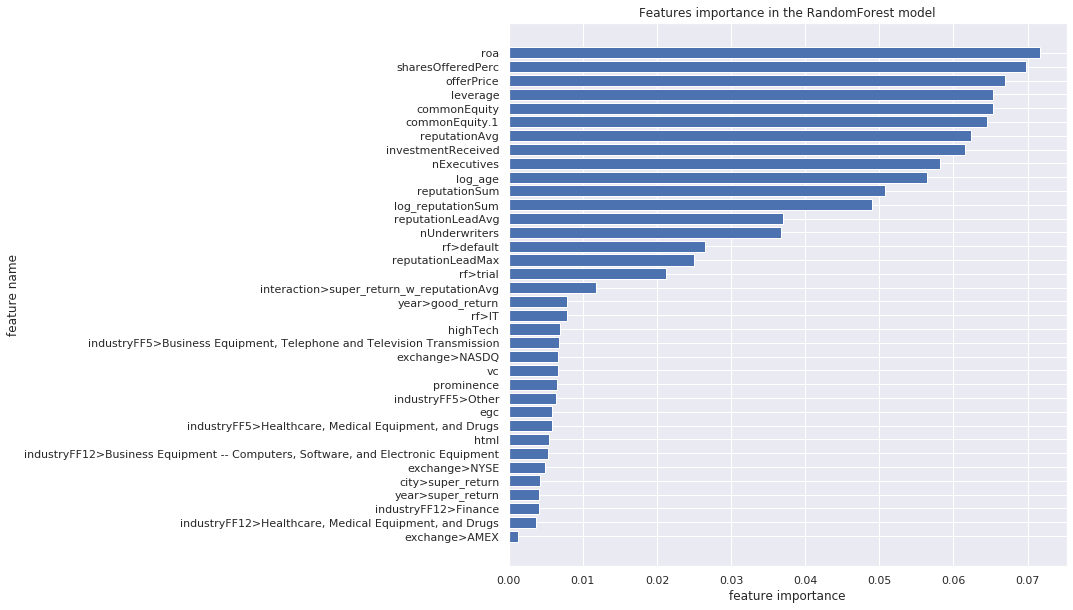



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


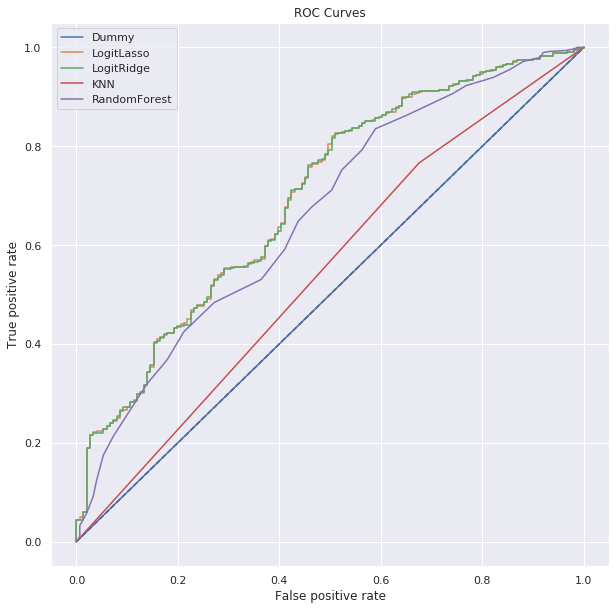

Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                           0.5              
          LogitLasso                 0.6960507187853335      
          LogitRidge                 0.6958891939912776      
             KNN                     0.5453817369299521      
         RandomForest                0.6618545738437517      



The best model for this prediction is  LogitLasso
It yields a score of  0.6960507187853335


Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.


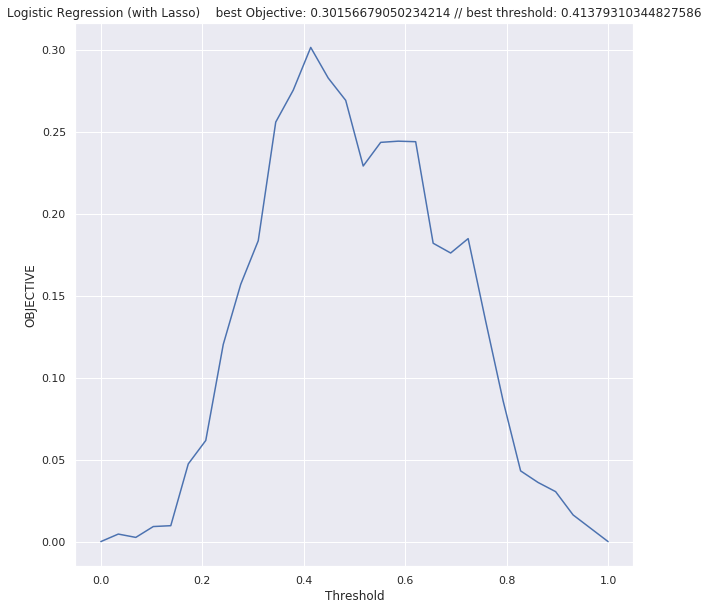

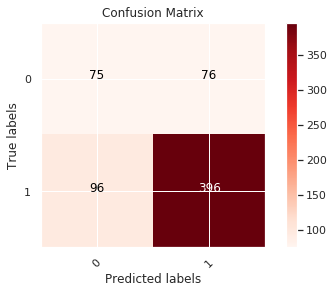

In [26]:
X_P3            = X.copy()
X_train_P3      = X_train.copy()
X_test_P3       = X_test.copy()
X_to_predict_P3 = X_to_predict.copy()
Y_train_P3      = (Y_train > 0).astype(int)
Y_test_P3       = (Y_test > 0).astype(int)
Y_P3            = (Y > 0).astype(int)

sns.countplot(data=Y_train_P3,x='Y')
plt.show()

P3, best_model_P3, best_score_P3 = compare_models(X=X_P3, Y=Y_P3, X_train=X_train_P3, Y_train=Y_train_P3, X_test=X_test_P3, Y_test=Y_test_P3, X_to_predict=X_to_predict_P3, 
                                                  score=roc_auc_score, maximize=True, predict_proba=False)

- Lasso regression is evaluated as to be the most performant model for this prediction task according to **roc AUC**
on the test set. 
- When tuning the probability threshold, we see on the correlation matrix (evaluated on test set)
that we have a good **TPR** $\approx 0.8$ but a **FPR** > 0.5. It is the concern of the decision maker to know whether
he prefers to have a high hit rate, or a low false alarm rate, meaning: is it more paintful to have
    a share misclassified as underpriced? Or to have a share misclassified as overpriced?

In [63]:
P3

array([ True, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False,  True, False,  True, False, False,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False, False, False,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [0]:
IPO_file['P3'] = P3

# A.4 P4

Here we are facing an imbalacanded classification problem in the other way around. There are less samples whose
underpricing is above 20% than under 20%. The imbalance is not as marked as the previous prediction problem, but the problem is still imbalanced as there are 2 times more negative events than positive events.

- We use the **roc AUC** for model selection and the custom score **TPR-FPR** for tuning the threshold.

We recall that the motivation behind this custom score is that we are equally interested in maximizing the hit rate while minimizing the false alarm rate (i.e. predicted as underpriced while in reality is is overpriced).

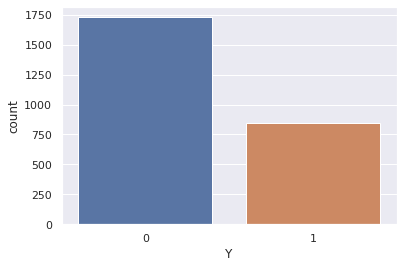

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.3min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.2s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  4.6min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                  2.0235896477251556      
          LogitLasso                    class weight                     balanced           
          LogitRidge                     penalty C                  21.209508879201927      
          LogitRidge                    class weight                     balanced           
             KNN                   number of neighbors K                   409              
         RandomForest          number of features to select k               41              
         RandomForest                 number of trees                      200              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

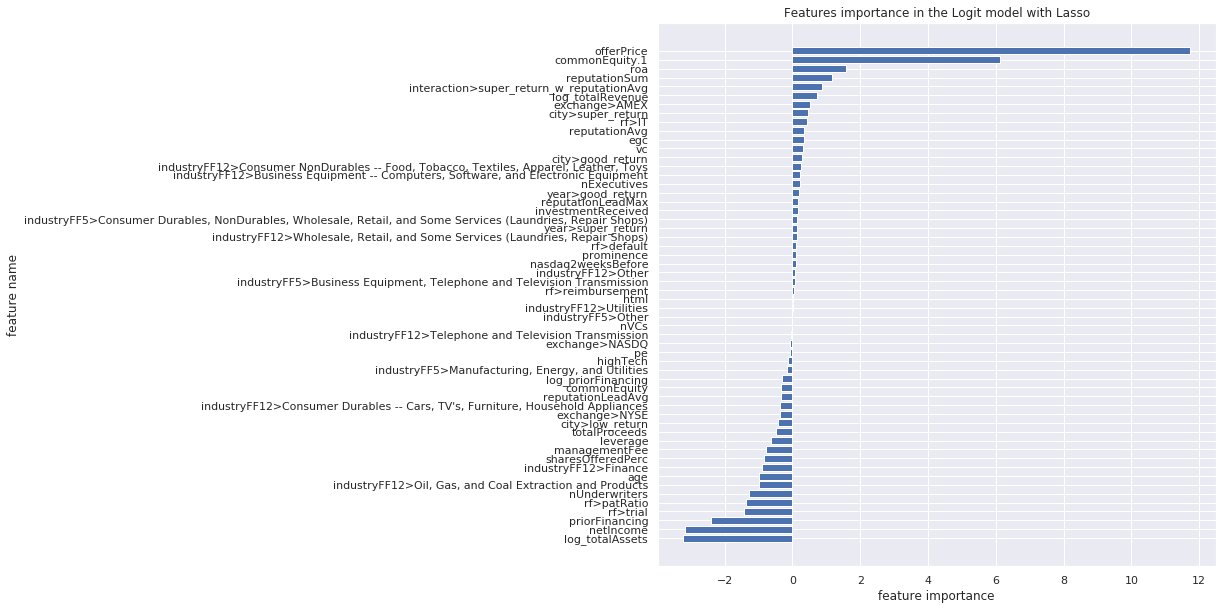

In the graph below you can see the features importance for the logit model with Ridge regularization : 



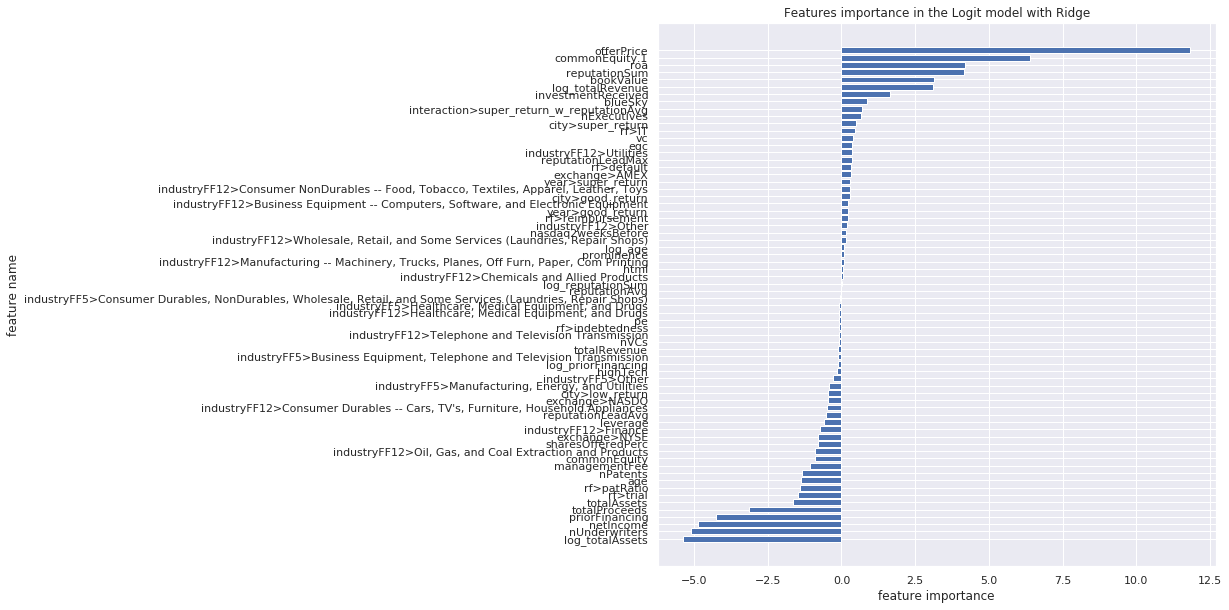

In the graph below you can see the features importance for the RandomForest model: 



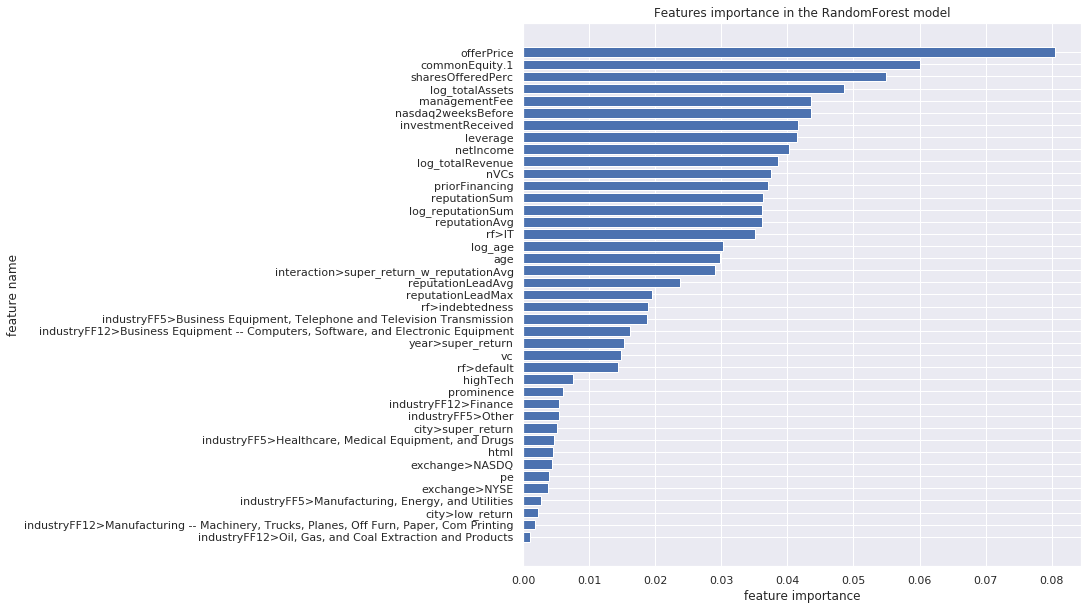



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


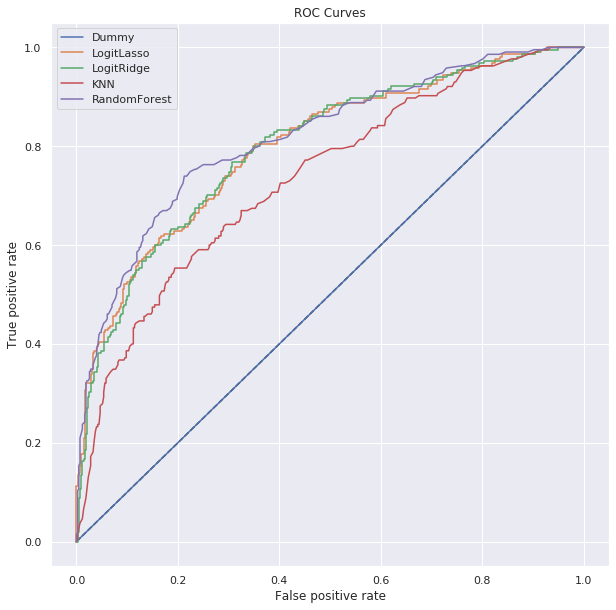

Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                           0.5              
          LogitLasso                 0.800043468811128       
          LogitRidge                 0.7988046076939795      
             KNN                     0.7348837209302326      
         RandomForest                0.8169745707454902      



The best model for this prediction is  RandomForest
It yields a score of  0.8169745707454902


Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.


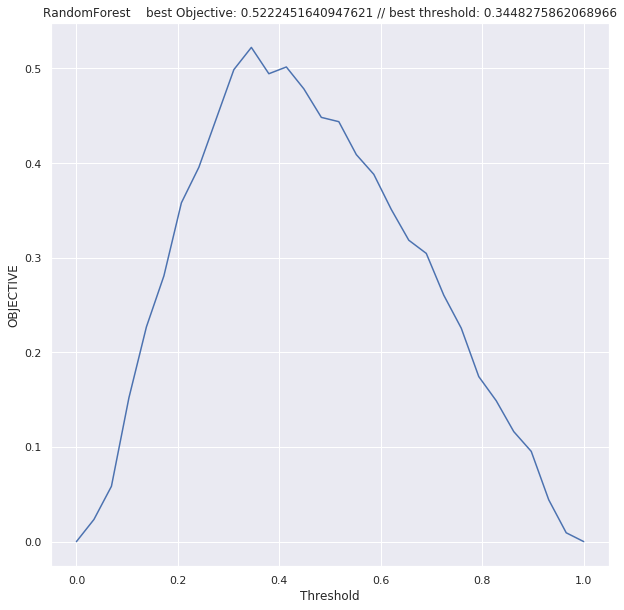

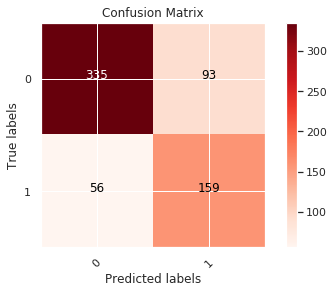

In [28]:
X_P4            = X.copy()
X_train_P4      = X_train.copy()
X_test_P4       = X_test.copy()
X_to_predict_P4 = X_to_predict.copy()
Y_train_P4      = (Y_train > 0.2).astype(int)
Y_test_P4       = (Y_test > 0.2).astype(int)
Y_P4            = (Y > 0.2).astype(int)

sns.countplot(data=Y_train_P4,x='Y')
plt.show()

P4, best_model_P4, best_score_P4 = compare_models(X=X_P4, Y=Y_P4, X_train=X_train_P4, Y_train=Y_train_P4, X_test=X_test_P4, Y_test=Y_test_P4, X_to_predict=X_to_predict_P4, score=roc_auc_score, maximize=True, predict_proba=False)

Interistingly, this time _Random Forest_ yields the best performance on hold out data. The objective 
of our custom score is also very high compared to **P3** with **TPR-FPR=29.9%** , where we manage to have a **TPR-FPR=52.2%** in **P4**. Models are performing way better when it is about differentiating "high underpricing" from normal underpricing and overpricing. In **P3**, it was about identifying overpricing, and models are less performant for this task.

Interistingly, risk factor have their degree of importance, especially `rf>IT` that was infered from LDA topic modelling. The most explainatory feature appears to be `offerPrice` this time. We see the importance of feature engineering.

In [62]:
P4

array([ True, False,  True,  True,  True, False, False, False, False,
        True, False, False, False,  True, False,  True,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True,  True,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True,  True, False,  True, False, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
       False, False,

In [0]:
IPO_file['P4'] = P4

# A.5 P5
* Predict whether the closing price at the end of the first day of trading will go __down__ by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0). 

It is an **HIGHLY** imbalanced problem, here the concern is to predict whether a stock will go down by more than 20 percents, and we have very few examples meeting this condition on the train set (36 actually). It is
difficult for a classifier to handle such a prediction problem.

We use the roc AUC to compute model performance and our traditional custom score for probability threshold.

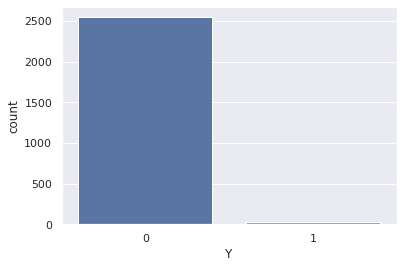

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.0min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.5s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  3.1min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                0.0071968567300115215     
          LogitLasso                    class weight                     balanced           
          LogitRidge                     penalty C                 0.018420699693267165     
          LogitRidge                    class weight                     balanced           
             KNN                   number of neighbors K                    6               
         RandomForest          number of features to select k               1               
         RandomForest                 number of trees                       50              
         RandomForest                   class weight                     balanced           


Models trained

Now we take a look at the importance attri

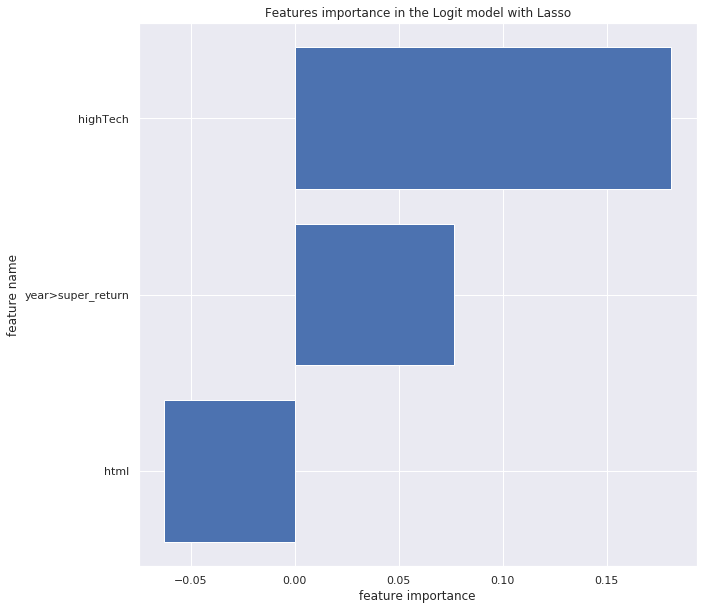

In the graph below you can see the features importance for the logit model with Ridge regularization : 



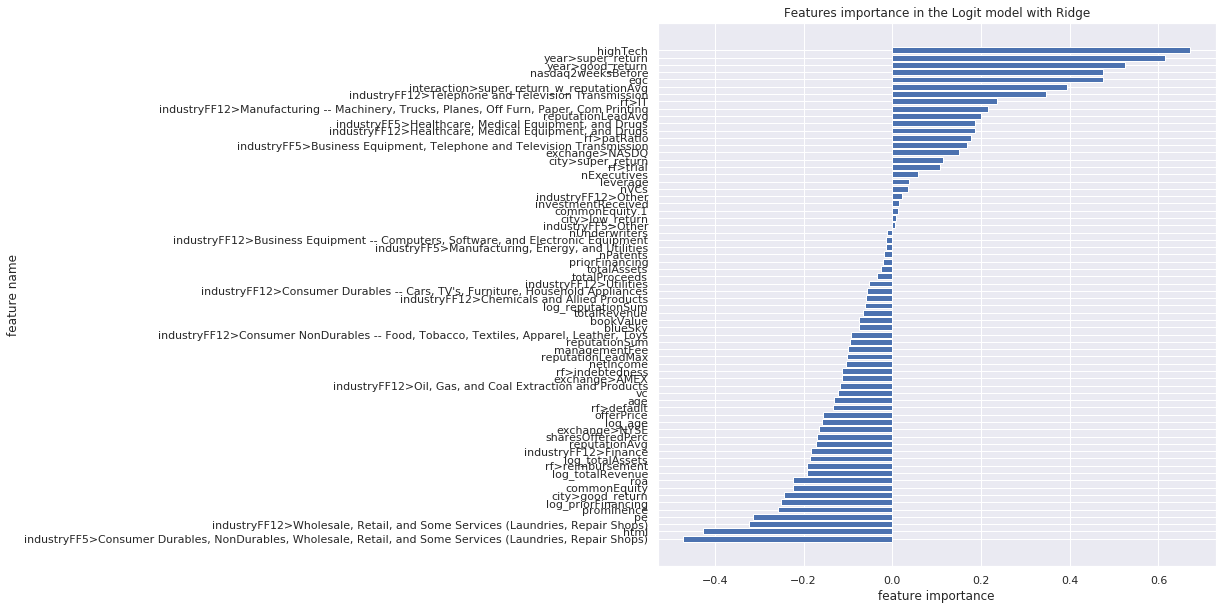

In the graph below you can see the features importance for the RandomForest model: 



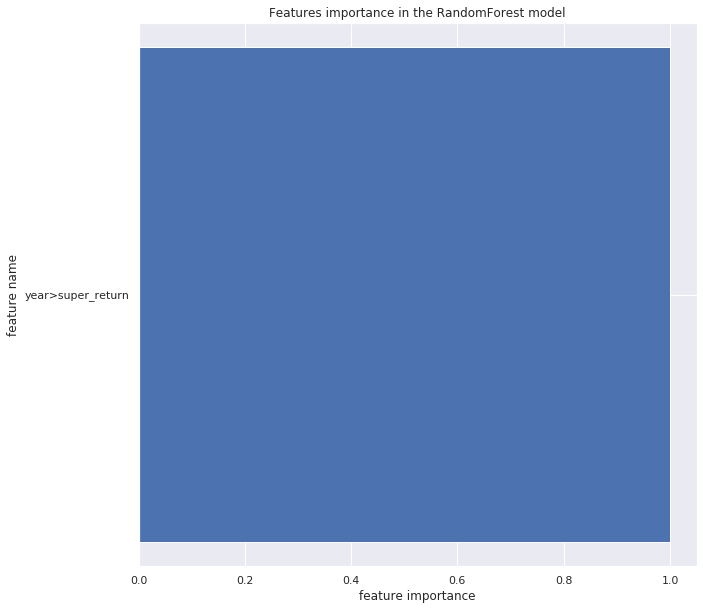



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


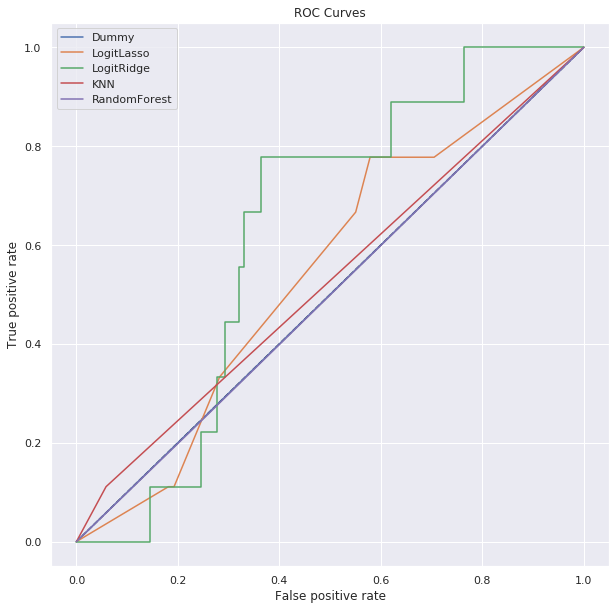

Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                           0.5              
          LogitLasso                 0.5461794602173151      
          LogitRidge                 0.6265334735366281      
             KNN                     0.5263757448300036      
         RandomForest                0.4991237294076411      



The best model for this prediction is  LogitRidge
It yields a score of  0.6265334735366281


Before making the prediction, we still need to determine which threshold to choose in order to have the best metric score.


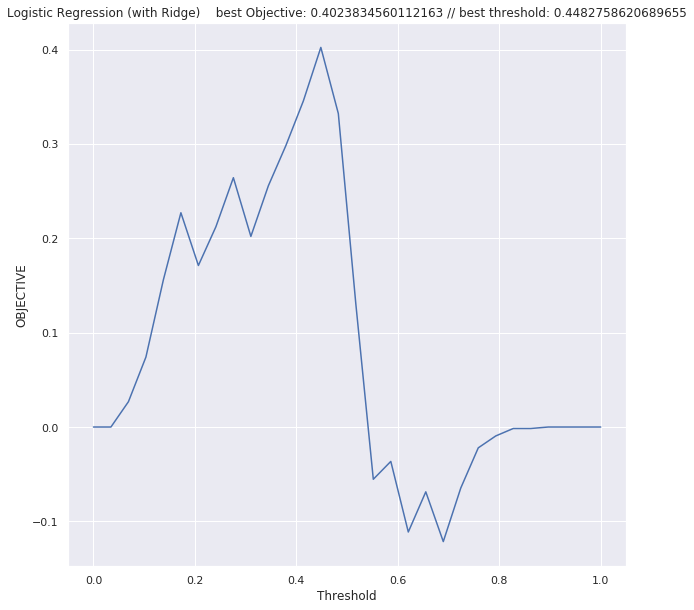

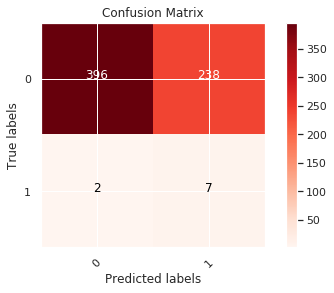

In [30]:
X_P5            = X.copy()
X_train_P5      = X_train.copy()
X_test_P5       = X_test.copy()
X_to_predict_P5 = X_to_predict.copy()
Y_train_P5      = (Y_train < -0.2).astype(int)
Y_test_P5       = (Y_test < -0.2).astype(int)
Y_P5            = (Y < -0.2).astype(int)

sns.countplot(data=Y_train_P5,x='Y')
plt.show()

P5, best_model_P5, best_score_P5 = compare_models(X=X_P5, Y=Y_P5, X_train=X_train_P5, Y_train=Y_train_P5, X_test=X_test_P5, Y_test=Y_test_P5, X_to_predict=X_to_predict_P5, 
                                                  score=roc_auc_score, maximize=True, predict_proba=False)

In [31]:
P5

array([ True, False,  True, False, False, False,  True,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False,  True, False,  True, False,  True, False, False,  True,
       False,  True, False,  True, False, False, False,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True,  True, False,  True,
       False, False,  True, False, False,  True, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False,  True, False, False,  True, False, False,  True,
        True, False, False,  True, False,  True, False, False, False,
        True, False,  True,  True, False,  True,  True, False, False,
        True, False, False,  True,  True, False, False,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False,  True,  True, False, False,  True,
        True, False,

The best model for this prediction is Logit with Ridge. It gives an AUC score of 0.62. From the confusion matrix we can see that there is a lot of False positives. We can conclude that although the ridge logit model gives a score higher than the baselines, it does not capture the high imblance of the dataset

In [0]:
IPO_file['P5'] = P5

# B. Regression task: P6
  
  * Predict the share price at the end of the first day. 


_It is the single regression problem where we try to predict the share price at the end of the day. One expect that `offerPrice` will be the most determinant variable for this problem._

- For this problem, the evaluation metric is the Negative Mean Squared Error (MSE).
Of course, we want it to be as close as possible from zero.

- As a baseline model, we use a simple **Linear Regression** without L1 nor L2 penalty. Then we train and tune a  **Random Forest Regressor**, **Lasso regression**, **Ridge regression** and **Support Vector Regression**.

In [0]:
X_P6 = X.copy()
X_train_P6 = X_train.copy()
X_test_P6 = X_test.copy()
X_to_predict_P6 = X_to_predict.copy()
Y_train_P6 = Y_train.values.reshape(-1)*X_train_P6['offerPrice'].values + X_train_P6['offerPrice'] 
Y_test_P6 = Y_test.values.reshape(-1)*X_test_P6['offerPrice'].values + X_test_P6['offerPrice']  
Y_P6  = Y.values.reshape(-1)*X_P6['offerPrice'].values + X_P6['offerPrice'] 

In [0]:
def evaluate_neg_MSE_regression(estimator,X_test,Y_test):
    
    Y_pred = estimator.predict(X_test)
    
    return - mean_squared_error(Y_test,Y_pred)

In [35]:
pipeline_linear_regression = Pipeline(steps=[('Scaler',MinMaxScaler()),('Model',LinearRegression())])
pipeline_rf = Pipeline(steps=[('Selection',SelectKBest(f_regression)),('Model',RandomForestRegressor(n_jobs=-1,random_state=SEED))])
grid_rf = {'Selection__k':list(range(1,X_train_P6.shape[1]+1,5)),'Model__n_estimators':[50,100,150,200]}
gs_rf = GridSearchCV(estimator=pipeline_rf,param_grid=grid_rf,scoring='neg_mean_squared_error',cv=5,verbose=1,n_jobs=-1)
gs_rf.fit(X_train_P6,Y_train_P6)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 11.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Selection',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x7fef7d92fd90>)),
                                       ('Model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                          

In [36]:
pipeline_ridge = Pipeline(steps=[('Scaler',MinMaxScaler()),('Model',Ridge(random_state=SEED))])
grid_ridge = {'Model__alpha':np.logspace(-4,4,num=50)}
gs_ridge = GridSearchCV(estimator=pipeline_ridge,param_grid=grid_ridge,scoring='neg_mean_squared_error',cv=5,verbose=1,n_jobs=-1)
gs_ridge.fit(X_train_P6,Y_train_P6)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    8.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('Model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=12345, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'Model__alpha': array([1.000...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.

In [37]:
pipeline_lasso = Pipeline(steps=[('Scaler',MinMaxScaler()),('Model',Lasso(random_state=SEED))])
grid_lasso = {'Model__alpha':np.logspace(-4,4,num=50)}
gs_lasso = GridSearchCV(estimator=pipeline_lasso,param_grid=grid_lasso,scoring='neg_mean_squared_error',cv=5,verbose=1,n_jobs=-1)
gs_lasso.fit(X_train_P6,Y_train_P6)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   11.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('Model',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=12345,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006

In [38]:
pipeline_svr = Pipeline(steps=[('Scaler',MinMaxScaler()),('Model',SVR())])
grid_svr = {'Model__C':np.logspace(-4,4,num=40)}
gs_svr = GridSearchCV(estimator=pipeline_svr,param_grid=grid_svr,scoring='neg_mean_squared_error',cv=5,verbose=1,n_jobs=-1)
gs_svr.fit(X_train_P6,Y_train_P6)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('Model',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'Mo...
       1.26638017e+00, 2.03091762e+00, 3.25702066e+00, 5.22334507e+00,
       8.37677640e+00, 1.34339933e+01, 2.15443469e+01, 3.4

In [39]:
print('Let us take a look at the best parameters found')
print('Model'.center(30), 'Parameters'.center(30), 'Best Value'.center(30))
print('='*90)
print(str('Lasso').center(30), str('Alpha').center(30), str(gs_lasso.best_params_['Model__alpha']).center(30))
print(str('Ridge').center(30), str('Alpha').center(30), str(gs_ridge.best_params_['Model__alpha']).center(30))
print(str('RandomForest').center(30), str('number of features to select k').center(30), str(gs_rf.best_params_['Selection__k']).center(30))
print(str('RandomForest').center(30), str('number of trees').center(30), str(gs_rf.best_params_['Model__n_estimators']).center(30))
print(str('SVR').center(30), str('Penalty C').center(30), str(gs_svr.best_params_['Model__C']).center(30))
print('\n')

pipeline_rf.set_params(Selection__k = gs_rf.best_params_['Selection__k'], Model__n_estimators = gs_rf.best_params_['Model__n_estimators'])
pipeline_ridge.set_params(Model__alpha = gs_ridge.best_params_['Model__alpha'])
pipeline_lasso.set_params(Model__alpha = gs_lasso.best_params_['Model__alpha'])
pipeline_svr.set_params(Model__C = gs_svr.best_params_['Model__C'])

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
            Lasso                          Alpha                   0.009102981779915217     
            Ridge                          Alpha                    0.2682695795279725      
         RandomForest          number of features to select k               16              
         RandomForest                 number of trees                      200              
             SVR                         Penalty C                       10000.0            




Pipeline(memory=None,
         steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Model',
                 SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [40]:
pipeline_linear_regression.fit(X_train_P6,Y_train_P6)
pipeline_rf.fit(X_train_P6,Y_train_P6)
pipeline_ridge.fit(X_train_P6,Y_train_P6)
pipeline_lasso.fit(X_train_P6,Y_train_P6)
pipeline_svr.fit(X_train_P6,Y_train_P6)

Pipeline(memory=None,
         steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Model',
                 SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In the graph below you can see the features importance for the RandomForest model: 



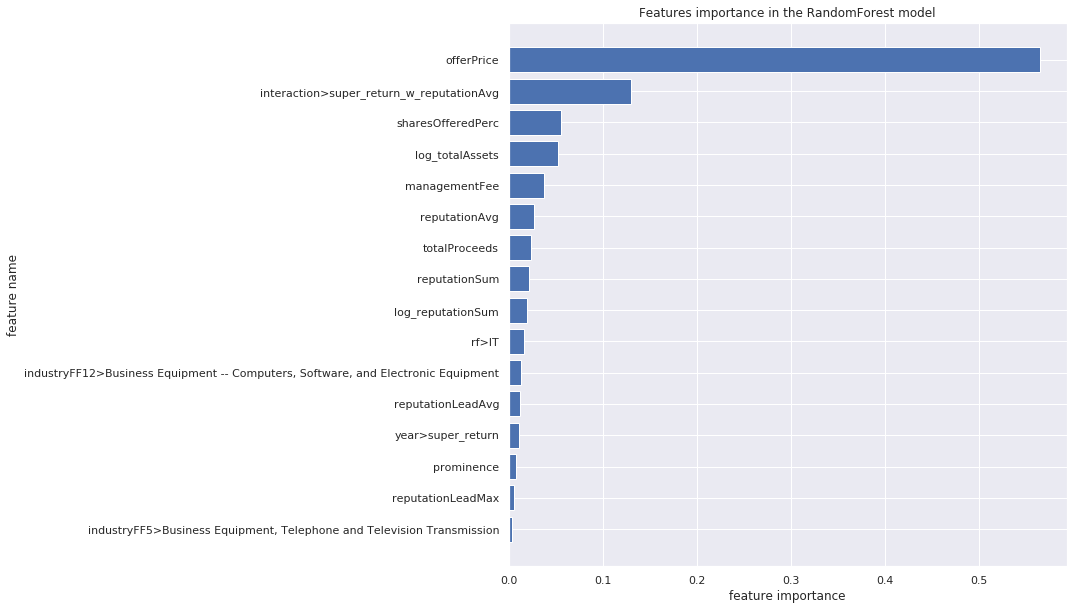

In [41]:
print('In the graph below you can see the features importance for the RandomForest model: \n')
feature_importance_rf(pipeline_rf, X_train_P6, Y_train_P6, 'Features importance in the RandomForest model')
print('\n')

In [0]:
score_linear_regression = evaluate_neg_MSE_regression(pipeline_linear_regression,X_test_P6,Y_test_P6)
score_rf = evaluate_neg_MSE_regression(pipeline_rf,X_test_P6,Y_test_P6)
score_ridge = evaluate_neg_MSE_regression(pipeline_ridge,X_test_P6,Y_test_P6)
score_lasso = evaluate_neg_MSE_regression(pipeline_lasso,X_test_P6,Y_test_P6)
score_svr = evaluate_neg_MSE_regression(pipeline_svr,X_test_P6,Y_test_P6)

In [43]:
scores = [score_linear_regression, score_rf, score_ridge, score_lasso, score_svr]
models = ['Linear Reression', 'RandomForest','RIDGE','LASSO','SVR']

ind, best_score_P6 = max(enumerate(scores), key=operator.itemgetter(1))
best_model_P6 = models[ind]

print ('We need to compare the scores between models in order to make our choice, the table below makes the comparison easier')
print('Model'.center(30), 'Score'.center(30))
print('='*60)
for i in range(5):
    print(str(models[i]).center(30), str(scores[i]).center(30))

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
       Linear Reression             -175.32692879731758      
         RandomForest               -101.99702788992829      
            RIDGE                    -175.9334934791014      
            LASSO                    -175.857569346854       
             SVR                     -150.7068231598469      


In [44]:
print('The best model for this prediction is ', best_model_P6)
print('It yields a score of ', best_score_P6)

The best model for this prediction is  RandomForest
It yields a score of  -101.99702788992829


In [0]:
pipeline_rf.fit(X_P6,Y_P6)
P6 = pipeline_rf.predict(X_to_predict_P6)

From score on test set, we choose Random Forest (RF). Note that the average score during cross validation is more optimistic that the one obtained on test set.  As expected, `offerPrice` is the most important feature. Interistingly, the hand engineered interaction between 
`reputationAvg` and super return is the second most important feature.

In [61]:
P6

array([ 34.79985375,  14.159325  ,  54.4       ,  21.169025  ,
        35.5040375 ,  23.0849    ,   8.26181565,  10.3663125 ,
        12.57885625,   6.2657415 ,   5.9288375 ,   8.9395375 ,
        13.88315   ,  20.7850875 ,  11.1206    ,  60.2684375 ,
        30.2939845 ,  20.8878    ,  23.5189469 ,  19.1322625 ,
        13.9092375 ,  23.8662251 ,  19.672525  ,   9.5813719 ,
        18.1174438 ,  12.2057    ,   9.90704375,  21.7181375 ,
        27.7078128 ,   6.522025  ,  33.4710844 ,  23.253825  ,
        13.650875  ,  26.0379625 ,  26.5582625 ,  27.3494375 ,
        27.8655126 ,  14.68226565,  12.14750625,  27.4706813 ,
        16.9749721 ,  17.0467469 ,  26.335075  ,  20.44095   ,
        15.2104375 ,   6.64915   ,  17.5394844 ,  12.507575  ,
        13.02551565,  10.2036875 ,  20.5425875 ,  18.436875  ,
         9.25885625,   9.985425  ,  18.4794657 ,  15.9432375 ,
        18.43621575,  10.12848125,  19.218685  ,  15.0293469 ,
        24.473075  ,  13.7473688 ,  17.52621875,  12.36

In [0]:
IPO_file['P6'] = P6

# C. Custom metric, probabilistic classification: P7, P8, P9

For these classification problems, they have their own scoring metric based on penalization of deviation (in terms of probability) from the true label. 

- Model selection is made through this own scoring metric. These scores are formulated as penalties, and therefore we take the model that **Minimize** this score
- No need to optimize the threshold since we do not retrieve class, but instead probabilities of the **POSITIVE** event

# C.1 P7

For P7, we evaluate the performance on a custom metric that penalize the squared of deviation in terms of probability from the true label.

The prediction problem is the most balanced so far, it is about predicting whether the share price will go up 
by 5%. From past prediction problem, we may expect that the best model will perform quite well on such problem.


In [0]:
def P7_score(y_true, y_pred):
    scores = np.zeros((len(y_true), 1))
    y_pred *= 100
    for i in range(len(y_true)):
        if y_true[i] == False:
            scores[i] = y_pred[i]**2
        else:
            scores[i] = (100-y_pred[i])**2
    print(np.mean(scores))
    return np.abs(np.mean(scores))
P7_scorer = make_scorer(P7_score, greater_is_better=False, needs_proba=True)

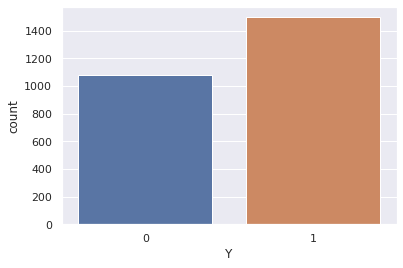

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 374 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.8min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.2s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  4.9min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                  2.0235896477251556      
          LogitLasso                    class weight                       None             
          LogitRidge                     penalty C                  9540.954763499964       
          LogitRidge                    class weight                       None             
             KNN                   number of neighbors K                   358              
         RandomForest          number of features to select k               56              
         RandomForest                 number of trees                      200              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

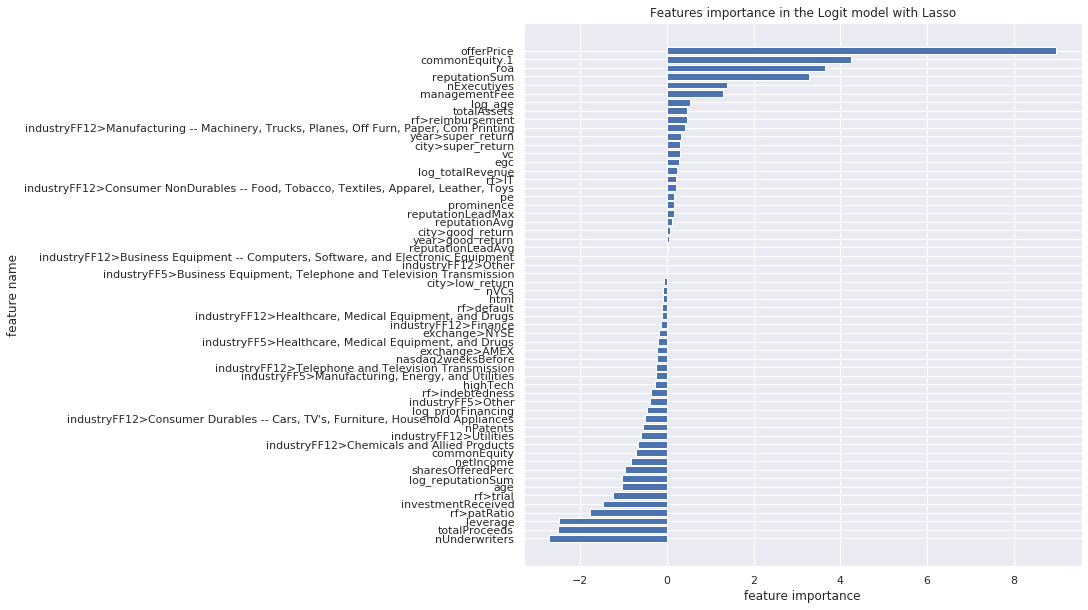

In the graph below you can see the features importance for the logit model with Ridge regularization : 



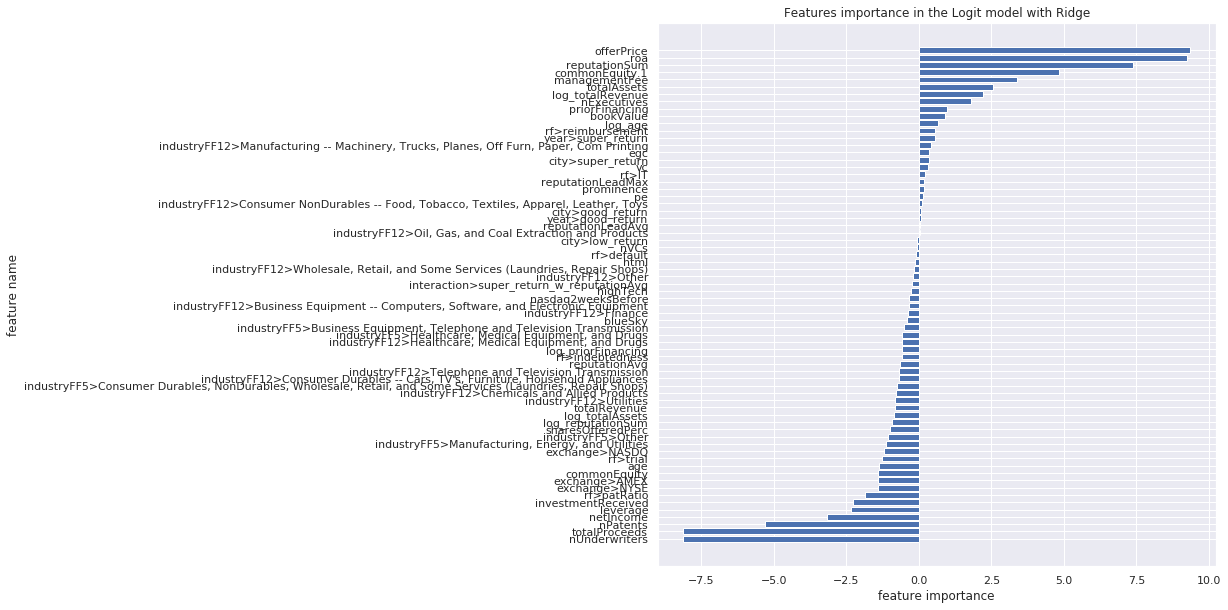

In the graph below you can see the features importance for the RandomForest model: 



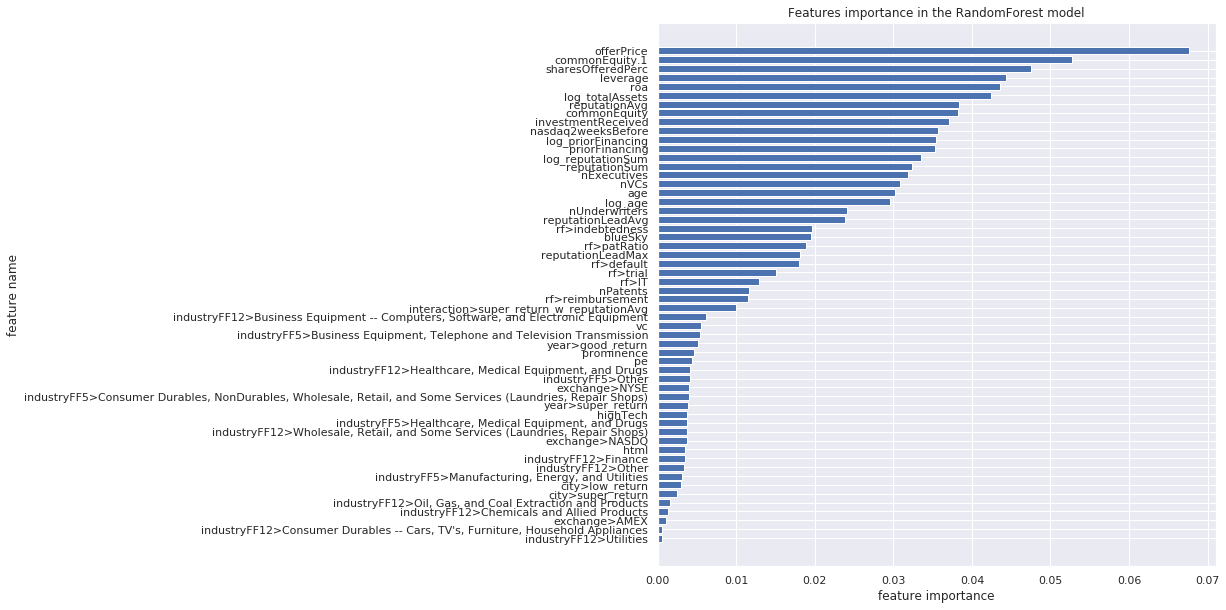



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


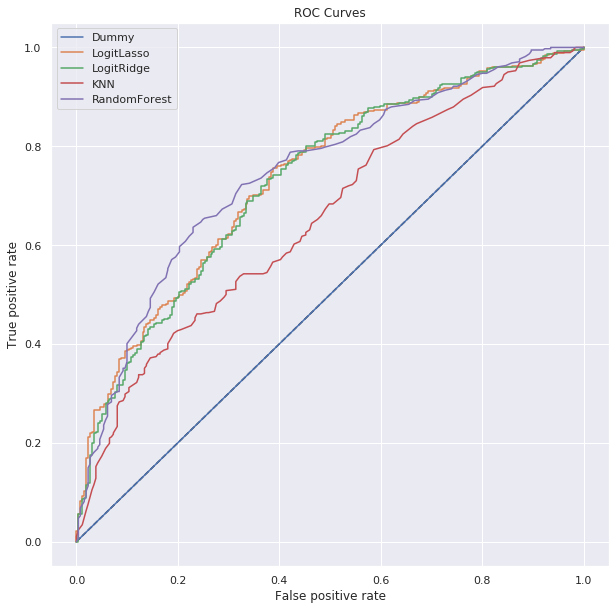

2413.0182924617066
2035.8180418588174
2052.4686266814074
2246.4093075148708
1995.851866251944
Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                    2413.0182924617066      
          LogitLasso                 2035.8180418588174      
          LogitRidge                 2052.4686266814074      
             KNN                     2246.4093075148708      
         RandomForest                1995.851866251944       



The best model for this prediction is  RandomForest
It yields a score of  1995.851866251944




In [48]:
X_P7            = X.copy()
X_train_P7      = X_train.copy()
X_test_P7       = X_test.copy()
X_to_predict_P7 = X_to_predict.copy()
Y_train_P7      = (Y_train  > 0.05).astype(int)
Y_test_P7       = (Y_test  > 0.05).astype(int)
Y_P7            = (Y > 0.05).astype(int)

sns.countplot(data=Y_train_P7,x='Y')
plt.show()

P7, best_model_P7, best_score_P7 = compare_models(X=X_P7, Y=Y_P7, X_train=X_train_P7, Y_train=Y_train_P7, X_test=X_test_P7, Y_test=Y_test_P7, X_to_predict=X_to_predict_P7, score=P7_score, maximize=False, predict_proba=True)

Best score is obtained with Random Forest, the roc curve does not really have something to share with the custom **P7**
score. However, it shows how the model performs if it was a deterministic classification task (meaning predicting labels, not probabilities).

In [60]:
P7

array([0.935, 0.36 , 0.795, 0.585, 0.645, 0.66 , 0.435, 0.48 , 0.54 ,
       0.47 , 0.335, 0.345, 0.405, 0.57 , 0.445, 0.765, 0.895, 0.475,
       0.58 , 0.48 , 0.545, 0.685, 0.25 , 0.535, 0.67 , 0.39 , 0.39 ,
       0.43 , 0.715, 0.675, 0.735, 0.55 , 0.515, 0.625, 0.73 , 0.845,
       0.735, 0.48 , 0.565, 0.645, 0.705, 0.625, 0.71 , 0.72 , 0.545,
       0.32 , 0.69 , 0.47 , 0.41 , 0.55 , 0.785, 0.835, 0.56 , 0.505,
       0.6  , 0.43 , 0.82 , 0.46 , 0.695, 0.55 , 0.555, 0.68 , 0.68 ,
       0.675, 0.67 , 0.85 , 0.575, 0.27 , 0.585, 0.87 , 0.59 , 0.555,
       0.395, 0.695, 0.735, 0.41 , 0.58 , 0.46 , 0.46 , 0.28 , 0.71 ,
       0.44 , 0.6  , 0.695, 0.78 , 0.835, 0.605, 0.525, 0.675, 0.605,
       0.74 , 0.55 , 0.53 , 0.84 , 0.61 , 0.5  , 0.505, 0.555, 0.68 ,
       0.575, 0.63 , 0.39 , 0.86 , 0.465, 0.51 , 0.355, 0.695, 0.52 ,
       0.655, 0.555, 0.61 , 0.495, 0.735, 0.545, 0.415, 0.375, 0.56 ,
       0.425, 0.495, 0.68 , 0.51 , 0.775, 0.845, 0.675, 0.795, 0.67 ,
       0.42 , 0.465,

In [0]:
IPO_file['P7'] = P7

# C.2 P8

Here we have again an highly imbalanced problem where the positive class is under represented. Predict whether
stock price will go up by more than 50%.

We use the same metric as for **P7**.

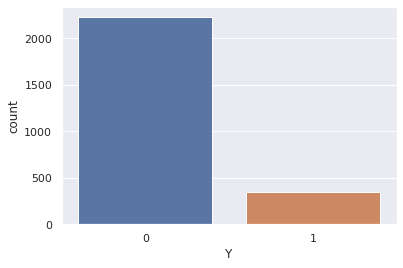

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.6min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.6s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  4.1min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                  13.257113655901108      
          LogitLasso                    class weight                       None             
          LogitRidge                     penalty C                  5963.623316594637       
          LogitRidge                    class weight                       None             
             KNN                   number of neighbors K                    6               
         RandomForest          number of features to select k               26              
         RandomForest                 number of trees                      100              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

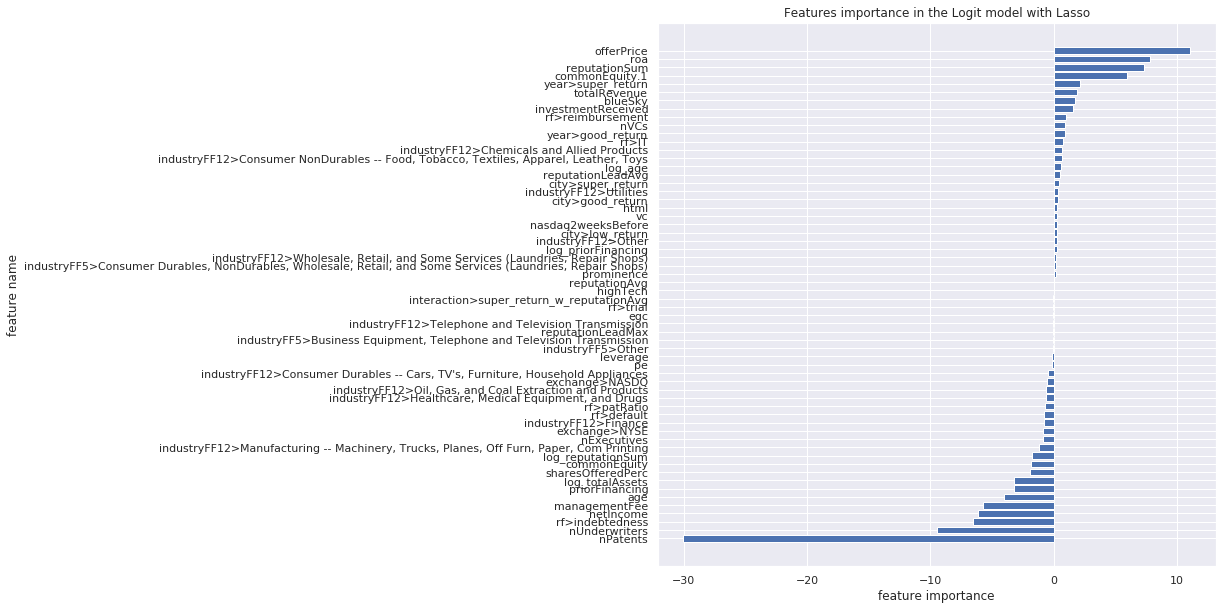

In the graph below you can see the features importance for the logit model with Ridge regularization : 



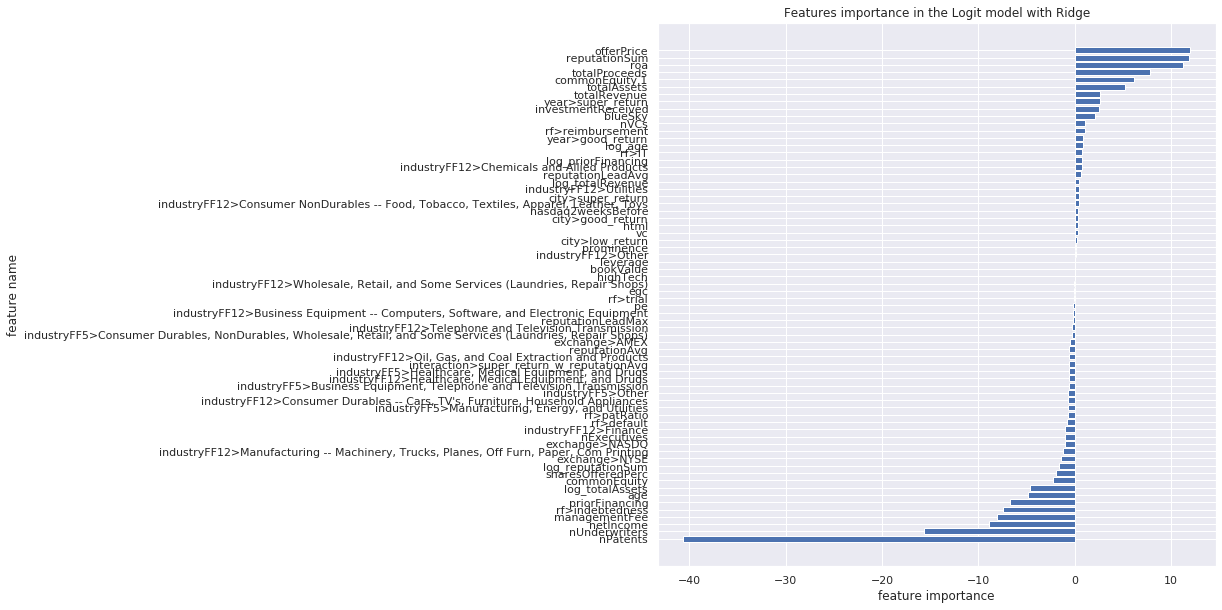

In the graph below you can see the features importance for the RandomForest model: 



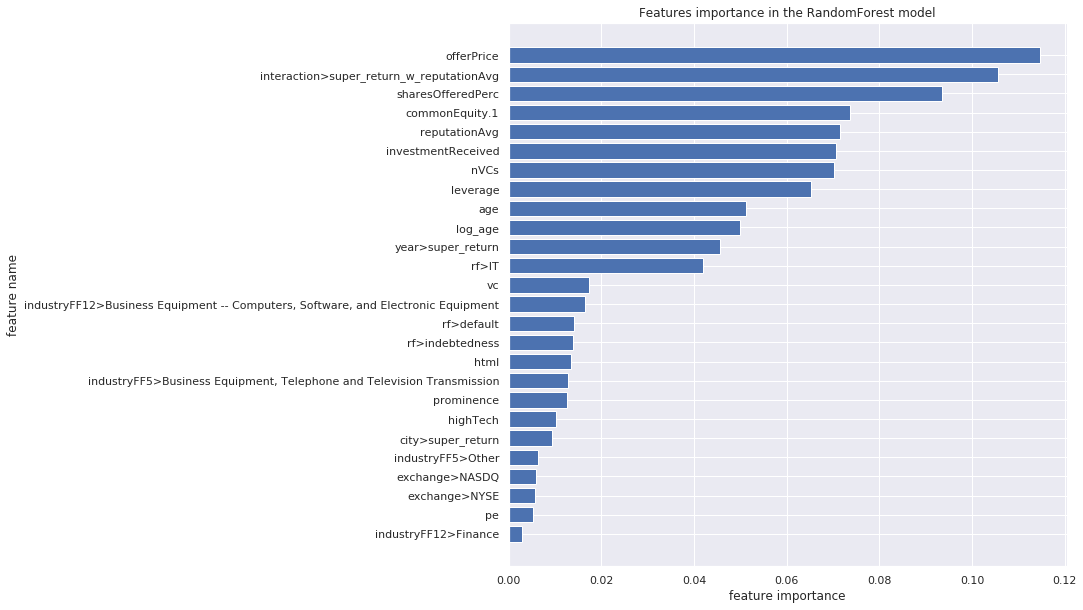



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


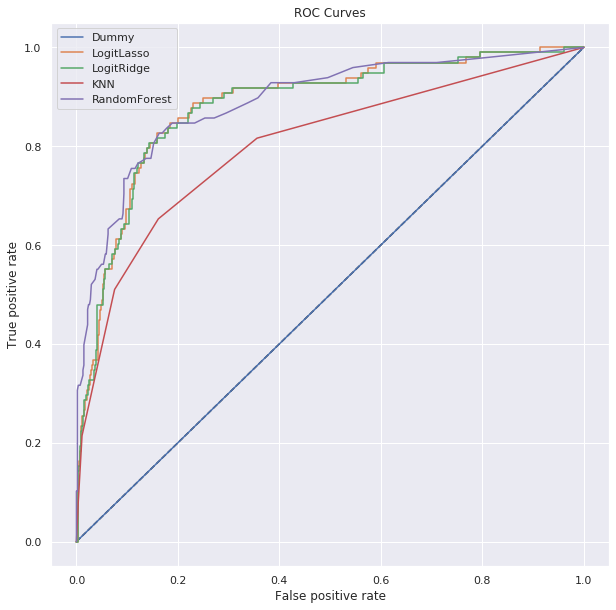

1295.445447927072
847.8568685410152
853.6365889665537
1019.9585277345774
765.1897356143079
Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                    1295.445447927072       
          LogitLasso                 847.8568685410152       
          LogitRidge                 853.6365889665537       
             KNN                     1019.9585277345774      
         RandomForest                765.1897356143079       



The best model for this prediction is  RandomForest
It yields a score of  765.1897356143079




In [50]:
X_P8            = X.copy()
X_train_P8      = X_train.copy()
X_test_P8       = X_test.copy()
X_to_predict_P8 = X_to_predict.copy()
Y_train_P8      = (Y_train  > 0.5).astype(int)
Y_test_P8       = (Y_test  > 0.5).astype(int)
Y_P8            = (Y > 0.5).astype(int)

sns.countplot(data=Y_train_P8,x='Y')
plt.show()

P8, best_model_P8, best_score_P8 = compare_models(X=X_P8, Y=Y_P8, X_train=X_train_P8, Y_train=Y_train_P8, X_test=X_test_P8, Y_test=Y_test_P8, X_to_predict=X_to_predict_P8, score=P7_score, maximize=False, predict_proba=True)

Again, Random Forest is performing better than the others. It is therefore good in differentiating high underpricing
from other cases. This prediction is our best one so far based on the ROC curves.

In [59]:
P8

array([0.74, 0.  , 0.88, 0.13, 0.08, 0.04, 0.06, 0.01, 0.02, 0.21, 0.04,
       0.02, 0.01, 0.08, 0.02, 0.29, 0.71, 0.03, 0.15, 0.25, 0.04, 0.37,
       0.  , 0.05, 0.  , 0.03, 0.01, 0.11, 0.58, 0.24, 0.36, 0.07, 0.05,
       0.05, 0.56, 0.56, 0.16, 0.01, 0.05, 0.15, 0.39, 0.15, 0.02, 0.09,
       0.02, 0.  , 0.02, 0.01, 0.02, 0.03, 0.18, 0.22, 0.05, 0.08, 0.01,
       0.03, 0.43, 0.  , 0.06, 0.27, 0.  , 0.07, 0.3 , 0.1 , 0.18, 0.11,
       0.3 , 0.06, 0.24, 0.18, 0.37, 0.05, 0.  , 0.39, 0.17, 0.01, 0.07,
       0.08, 0.01, 0.  , 0.57, 0.06, 0.03, 0.01, 0.2 , 0.17, 0.09, 0.02,
       0.33, 0.  , 0.07, 0.07, 0.03, 0.47, 0.06, 0.02, 0.01, 0.26, 0.12,
       0.14, 0.13, 0.01, 0.92, 0.08, 0.02, 0.  , 0.08, 0.18, 0.06, 0.  ,
       0.32, 0.05, 0.55, 0.21, 0.05, 0.01, 0.02, 0.02, 0.  , 0.25, 0.02,
       0.15, 0.7 , 0.18, 0.33, 0.23, 0.03, 0.02, 0.01, 0.34, 0.03, 0.9 ,
       0.04, 0.  , 0.06, 0.26, 0.13, 0.  , 0.  , 0.06, 0.01, 0.02, 0.44,
       0.14, 0.24, 0.19, 0.02, 0.08, 0.36, 0.2 , 0.

In [0]:
IPO_file['P8'] = P8

# C.3 P9

Compared to metric of **P8** and **P9**, this one penalizes less high deviation in terms of probability.

If deviation = |(TrueLabel - Pr(positive event))* 100 |, this model penalizes each observation by 2 x deviation,
while **P7** and **P8** penalizes by: 
- deviation x deviation

Highly imbalanced problem, predict whether it will go down by more than 10%, the positive case is when it goes
DOWN by more than 10%.

In [0]:
def P9_score(y_true, y_pred):
    scores = np.zeros((len(y_true), 1))
    y_pred *= 100
    for i in range(len(y_true)):
        if y_true[i] == False:
            scores[i] = y_pred[i]
        else:
            scores[i] = (100-y_pred[i])*2
    print(np.mean(scores))
    return np.abs(np.mean(scores))

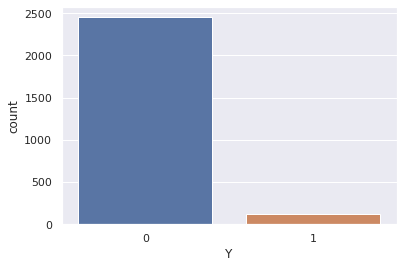

Models defined
Pipelines defined
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.6min finished


Lasso grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.3s finished


Ridge grid search done
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


KNN grid search done
Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  4.3min finished


Random Forest grid search done
Gird searches finished

Let us take a look at the best parameters found
            Model                        Parameters                     Best Value          
          LogitLasso                     penalty C                        1e-05             
          LogitLasso                    class weight                       None             
          LogitRidge                     penalty C                        1e-05             
          LogitRidge                    class weight                       None             
             KNN                   number of neighbors K                    11              
         RandomForest          number of features to select k               16              
         RandomForest                 number of trees                      200              
         RandomForest                   class weight                       None             


Models trained

Now we take a look at the importance attri

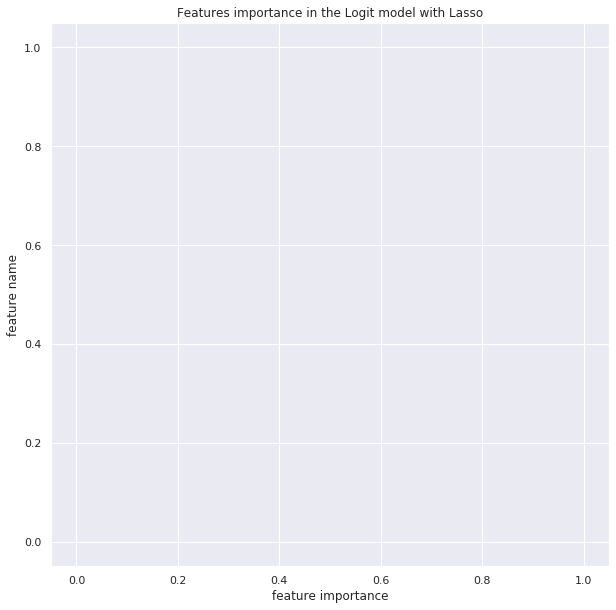

In the graph below you can see the features importance for the logit model with Ridge regularization : 



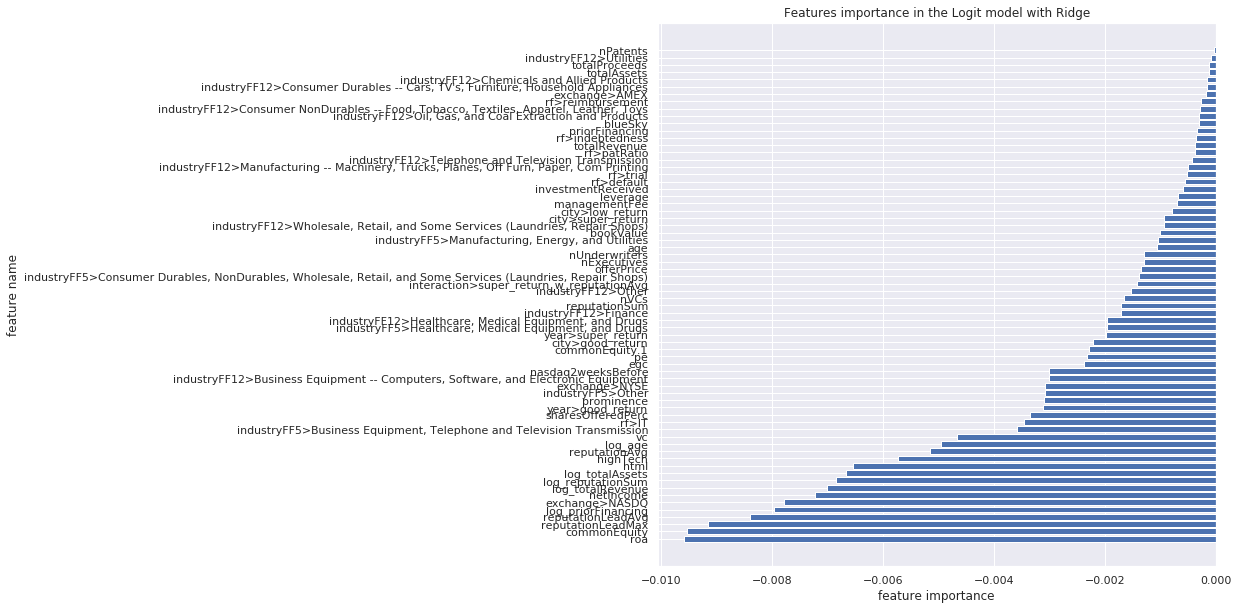

In the graph below you can see the features importance for the RandomForest model: 



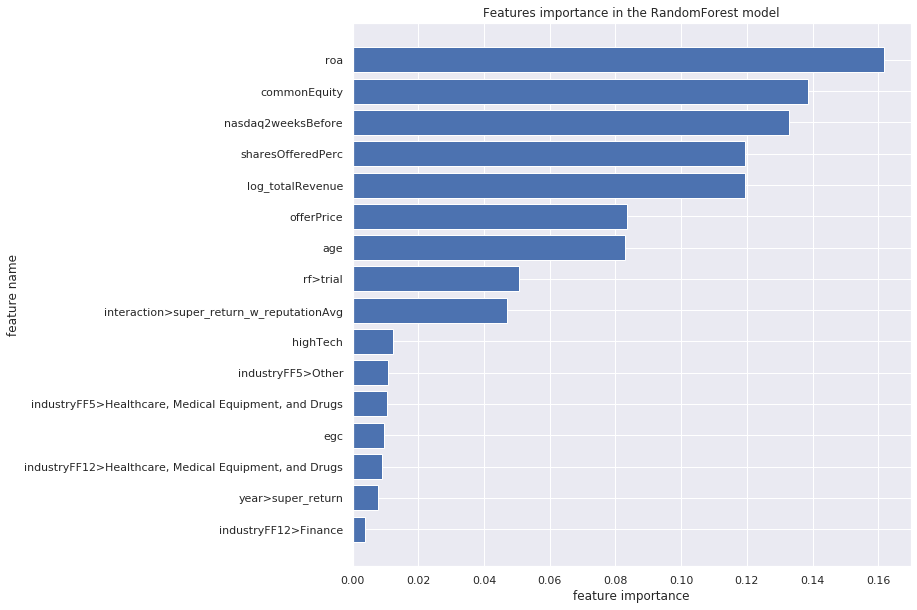



Models predictions computed

After computing the predicted probabilities for each model, let us take a look at their roc curves in order to have a first idea on which one performs better.


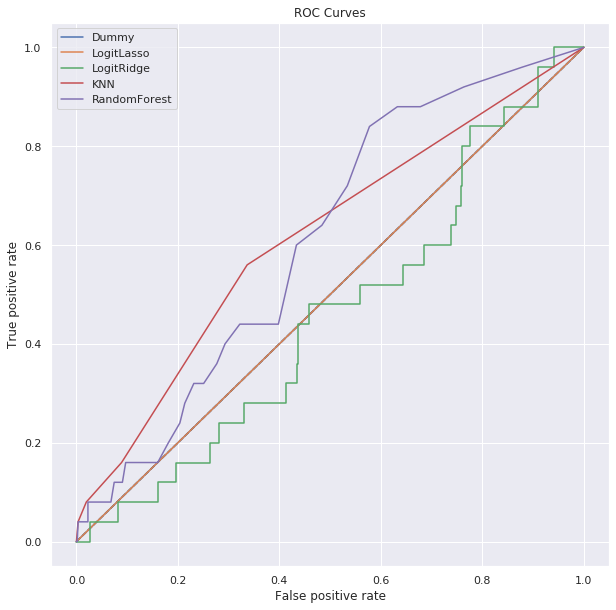

11.863131849393758
51.944012441679625
49.76785182511479
11.098543757952777
12.094090202177293
Scores computed and compared

We need to compare the scores between models in order to make our choice, the table below makes the comparison easier
            Model                          Score             
            Dummy                    11.863131849393758      
          LogitLasso                 51.944012441679625      
          LogitRidge                 49.76785182511479       
             KNN                     11.098543757952777      
         RandomForest                12.094090202177293      



The best model for this prediction is  KNN
It yields a score of  11.098543757952777




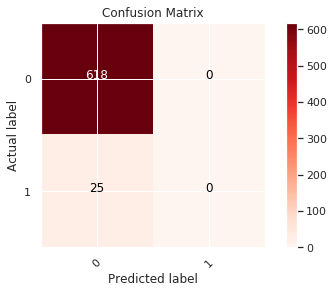

In [53]:
X_P9            = X.copy()
X_train_P9      = X_train.copy()
X_test_P9       = X_test.copy()
X_to_predict_P9 = X_to_predict.copy()
Y_train_P9      = (Y_train  < -0.1).astype(int)
Y_test_P9       = (Y_test  < -0.1).astype(int)
Y_P9            = (Y < -0.1).astype(int)

sns.countplot(data=Y_train_P9,x='Y')
plt.show()

P9, best_model_P9, best_score_P9 = compare_models(X=X_P9, Y=Y_P9, X_train=X_train_P9, Y_train=Y_train_P9, X_test=X_test_P9, Y_test=Y_test_P9, X_to_predict=X_to_predict_P9, score=P9_score, maximize=False, predict_proba=True)

For this last prediction, baseline classifier Dummy and KNN perform better than the others! It is probably due to the high class imbalance, 
classifiers fail to capture characteristics of the positive class (overpricing > 10%) and therefore behaves badly. Since the dummy score is of 11.86, the KNN score is really close to random and can be qualified as bad. However based on the ROC curves, we can see that KNN does actually better than the dummy classifier, and that randomForest is also a competitor.


In [58]:
P9

array([0.09090909, 0.        , 0.09090909, 0.        , 0.        ,
       0.09090909, 0.        , 0.27272727, 0.        , 0.        ,
       0.        , 0.        , 0.09090909, 0.        , 0.        ,
       0.27272727, 0.09090909, 0.        , 0.        , 0.18181818,
       0.09090909, 0.36363636, 0.        , 0.27272727, 0.        ,
       0.        , 0.18181818, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.36363636,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18181818, 0.        , 0.        , 0.        , 0.        ,
       0.18181818, 0.        , 0.        , 0.        , 0.27272727,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09090909, 0.09090909, 0.        , 0.09090909, 0.18181818,
       0.        , 0.        , 0.09090909, 0.        , 0.18181818,
       0.        , 0.09090909, 0.        , 0.09090909, 0.        ,
       0.        , 0.        , 0.        , 0.09090909, 0.18181

In [0]:
IPO_file['P9'] = P9

In [0]:
IPO_file.to_excel('IPO_data_to_predict.xlsx')

# D. Additional Discussion

_Areas of improvement:_
- To have a more accurate estimation of the generalization error, we could have adopted a Nested Cross Validation.
- Since risk factor features seem to have their degree of importance, it would have been interesting to go deeeper
  in risk factor feature engineering.
- We could have perform additional tuning on random forest, but we decided to keep things relatively simple as
  hyper parameter tuning improves slightly performance but leads to high computation cost.
- For highly imbalanced problems, we could have investigated under/oversampling techniques. From previous project, we have noticed that these techniques might improve slightly performance.

